# ? SOLAQUA - Raw Sensor Distance Analysis

**Direct analysis of raw distance measurements from bag file sensors (no image processing)**

This notebook analyzes ground truth sensor data from bag files:

- ? **Raw Navigation Data**: NetDistance from navigation_plane_approximation (primary sensor)
- 🎯 **Raw Guidance Data**: desired_net_distance and error_net_distance from guidance system  
- ⏰ **Timestamp Analysis**: Temporal patterns in raw sensor measurements
- 📊 **Statistical Analysis**: Raw sensor data characteristics and quality
- ? **No Image Processing**: Excludes any sonar image analysis artifacts

### Key Features:
- **Direct CSV Loading**: Fast access to raw sensor data without processing overhead
- **Ground Truth Focus**: Only actual sensor measurements from bag files
- **Multiple Distance Sources**: Navigation, guidance, and other available distance sensors
- **Temporal Analysis**: Time-series examination of raw measurements
- **Quality Assessment**: Validation of raw sensor data integrity

### Data Sources:
- `navigation_plane_approximation`: Primary NetDistance measurements
- `guidance`: Desired and error distance measurements  
- Other bag file sensors as available

---

In [1]:
# 🔧 IMPORT REQUIRED LIBRARIES
# ============================

# Core data manipulation
import pandas as pd
import numpy as np
from pathlib import Path
import json
from datetime import datetime
import warnings
import importlib

# Visualization
import matplotlib.pyplot as plt

# Enhanced plotting (optional)
try:
    import plotly.graph_objects as go
    import plotly.express as px
    HAS_PLOTLY = True
    print("📊 Plotly available for interactive visualizations")
except ImportError:
    HAS_PLOTLY = False
    print("📊 Using matplotlib for visualizations")

# SOLAQUA synchronized analysis utilities
import utils.synchronized_analysis as sync_analysis
importlib.reload(sync_analysis)  # Force reload to get latest changes
from utils.synchronized_analysis import SynchronizedAnalyzer, create_default_config, run_full_analysis

# Configuration
warnings.filterwarnings('ignore', category=FutureWarning)
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")
print(f"🔧 Enhanced features: Plotly={HAS_PLOTLY}")
print("🚀 Ready for synchronized analysis!")

📊 Plotly available for interactive visualizations
✅ All libraries imported successfully!
🔧 Enhanced features: Plotly=True
🚀 Ready for synchronized analysis!
✅ All libraries imported successfully!
🔧 Enhanced features: Plotly=True
🚀 Ready for synchronized analysis!


## ⚙️ Configuration

Set up analysis parameters and run the complete synchronized analysis pipeline.

In [2]:
# 🔧 QUICK RAW SENSOR DATA LOADING
# =====================================

print("⚙️ LOADING RAW SENSOR DATA (OPTIMIZED)")
print("=" * 45)
print("🚫 EXCLUDING: Sonar image analysis (not raw sensor data)")
print("✅ INCLUDING: Raw navigation NetDistance only")
print()

# Direct file loading (much faster than going through analyzers)
bag_name = "2024-08-22_14-29-05"  
print(f"📊 Loading raw data for bag: {bag_name}")

# Load raw navigation NetDistance directly
nav_file = f"exports/by_bag/navigation_plane_approximation__{bag_name}_data.csv"
print(f"📡 Loading navigation data from: {nav_file}")

try:
    # Load only essential columns for speed
    nav_data = pd.read_csv(nav_file, usecols=['ts_oslo', 'NetDistance', 'Altitude'])
    
    # Quick timestamp conversion (only parse what we need)
    nav_data['timestamp'] = pd.to_datetime(nav_data['ts_oslo']).dt.tz_convert('UTC')
    nav_data['net_distance_m_raw'] = nav_data['NetDistance']
    
    print(f"   ✅ Loaded {len(nav_data)} navigation records")
    print(f"   📏 NetDistance range: {nav_data['NetDistance'].min():.3f} - {nav_data['NetDistance'].max():.3f}m")
    print(f"   📊 NetDistance mean: {nav_data['NetDistance'].mean():.3f} ± {nav_data['NetDistance'].std():.3f}m")
    
    RAW_NAV_DATA = nav_data[['timestamp', 'net_distance_m_raw', 'NetDistance', 'Altitude']].copy()
    
except Exception as e:
    print(f"   ❌ Error loading navigation data: {e}")
    RAW_NAV_DATA = None

# Optionally load guidance data (smaller file, faster)
guidance_file = f"exports/by_bag/guidance__{bag_name}_data.csv"
print(f"\n🎯 Loading guidance data from: {guidance_file}")

try:
    # Check if file exists and get column info quickly
    guidance_data = pd.read_csv(guidance_file, nrows=1)  # Just peek at columns
    available_cols = guidance_data.columns.tolist()
    
    # Load only if we have distance columns
    distance_cols = [col for col in available_cols if 'distance' in col.lower()]
    
    if distance_cols:
        # Load full data with only needed columns
        load_cols = ['ts_oslo'] + distance_cols
        guidance_data = pd.read_csv(guidance_file, usecols=load_cols)
        guidance_data['timestamp'] = pd.to_datetime(guidance_data['ts_oslo']).dt.tz_convert('UTC')
        
        print(f"   ✅ Loaded {len(guidance_data)} guidance records")
        print(f"   📏 Available distance columns: {distance_cols}")
        
        RAW_GUIDANCE_DATA = guidance_data[['timestamp'] + distance_cols].copy()
    else:
        print(f"   ⚠️  No distance columns found in guidance data")
        RAW_GUIDANCE_DATA = None
        
except Exception as e:
    print(f"   ❌ Error loading guidance data: {e}")
    RAW_GUIDANCE_DATA = None

print(f"\n🎯 Raw sensor data loading complete!")
print("=" * 40)

# Quick summary
if RAW_NAV_DATA is not None:
    print(f"✅ Navigation: {len(RAW_NAV_DATA)} records, {RAW_NAV_DATA['NetDistance'].mean():.3f}m avg distance")

if RAW_GUIDANCE_DATA is not None:
    print(f"✅ Guidance: {len(RAW_GUIDANCE_DATA)} records")

# Also load DVL altimeter data for additional distance measurements
print(f"\n🔧 Loading DVL altimeter data...")
try:
    dvl_file = data_folder / "by_bag" / f"nucleus1000dvl_altimeter__{target_bag}_data.csv"
    if dvl_file.exists():
        RAW_DVL_DATA = pd.read_csv(dvl_file)
        RAW_DVL_DATA['timestamp'] = pd.to_datetime(RAW_DVL_DATA['ts_utc'])
        print(f"   ✅ Loaded {len(RAW_DVL_DATA)} DVL records")
        if 'altimeter_distance' in RAW_DVL_DATA.columns:
            dvl_distances = RAW_DVL_DATA['altimeter_distance'].dropna()
            print(f"   📏 Altimeter distance range: {dvl_distances.min():.3f} - {dvl_distances.max():.3f}m")
            print(f"   📊 Altimeter distance mean: {dvl_distances.mean():.3f} ± {dvl_distances.std():.3f}m")
    else:
        RAW_DVL_DATA = None
        print(f"   ❌ DVL altimeter file not found")
except Exception as e:
    RAW_DVL_DATA = None
    print(f"   ❌ Error loading DVL data: {e}")

print(f"\n⚡ Loading optimized - using direct CSV reading instead of analyzer classes")

⚙️ LOADING RAW SENSOR DATA (OPTIMIZED)
🚫 EXCLUDING: Sonar image analysis (not raw sensor data)
✅ INCLUDING: Raw navigation NetDistance only

📊 Loading raw data for bag: 2024-08-22_14-29-05
📡 Loading navigation data from: exports/by_bag/navigation_plane_approximation__2024-08-22_14-29-05_data.csv
   ✅ Loaded 525 navigation records
   📏 NetDistance range: 0.230 - 0.880m
   📊 NetDistance mean: 0.661 ± 0.102m

🎯 Loading guidance data from: exports/by_bag/guidance__2024-08-22_14-29-05_data.csv
   ✅ Loaded 518 guidance records
   📏 Available distance columns: ['error_net_distance', 'desired_net_distance', 'r_net_distance_d']

🎯 Raw sensor data loading complete!
✅ Navigation: 525 records, 0.661m avg distance
✅ Guidance: 518 records

🔧 Loading DVL altimeter data...
   ❌ Error loading DVL data: name 'data_folder' is not defined

⚡ Loading optimized - using direct CSV reading instead of analyzer classes


In [3]:
# 🔍 COMPREHENSIVE DISTANCE SENSOR LOADING
# ========================================

print("🔍 LOADING ALL AVAILABLE DISTANCE/POSITION SENSORS")
print("=" * 55)

target_bag = "2024-08-22_14-29-05"
data_folder = Path("/Users/eirikvarnes/code/SOLAQUA/exports")

# Dictionary to store all sensor data
SENSOR_DATA = {}

# 1. DVL Altimeter (altitude/distance to bottom)
print("📡 1. DVL Altimeter...")
try:
    dvl_alt_file = data_folder / "by_bag" / f"nucleus1000dvl_altimeter__{target_bag}_data.csv"
    if dvl_alt_file.exists():
        dvl_alt = pd.read_csv(dvl_alt_file)
        dvl_alt['timestamp'] = pd.to_datetime(dvl_alt['ts_utc'])
        SENSOR_DATA['dvl_altimeter'] = dvl_alt
        
        alt_distances = dvl_alt['altimeter_distance'].dropna()
        if len(alt_distances) > 0:
            print(f"   ✅ Loaded {len(dvl_alt)} records")
            print(f"   📏 Altimeter distance: {alt_distances.min():.3f} - {alt_distances.max():.3f}m")
            print(f"   📊 Mean: {alt_distances.mean():.3f} ± {alt_distances.std():.3f}m")
        else:
            print(f"   ⚠️  No valid altimeter distances")
    else:
        print(f"   ❌ File not found")
except Exception as e:
    print(f"   ❌ Error: {e}")

# 2. DVL Bottomtrack (beam distances)
print("\n📡 2. DVL Bottomtrack...")
try:
    dvl_bt_file = data_folder / "by_bag" / f"nucleus1000dvl_bottomtrack__{target_bag}_data.csv"
    if dvl_bt_file.exists():
        dvl_bt = pd.read_csv(dvl_bt_file)
        dvl_bt['timestamp'] = pd.to_datetime(dvl_bt['ts_utc'])
        SENSOR_DATA['dvl_bottomtrack'] = dvl_bt
        
        print(f"   ✅ Loaded {len(dvl_bt)} records")
        if 'beam_distance' in dvl_bt.columns:
            print(f"   📏 Has beam_distance column")
        else:
            print(f"   ⚠️  No beam_distance column")
        print(f"   📊 Available columns: {[col for col in dvl_bt.columns if 'distance' in col.lower() or 'range' in col.lower()]}")
    else:
        print(f"   ❌ File not found")
except Exception as e:
    print(f"   ❌ Error: {e}")

# 3. USBL (acoustic positioning)
print("\n📡 3. USBL Sensor...")
try:
    usbl_file = data_folder / "by_bag" / f"sensor_usbl__{target_bag}_data.csv"
    if usbl_file.exists():
        usbl = pd.read_csv(usbl_file)
        usbl['timestamp'] = pd.to_datetime(usbl['ts_utc'])
        SENSOR_DATA['usbl'] = usbl
        
        print(f"   ✅ Loaded {len(usbl)} records")
        # Calculate distance from east/north/depth
        if all(col in usbl.columns for col in ['east', 'north', 'depth']):
            usbl['usbl_distance'] = np.sqrt(usbl['east']**2 + usbl['north']**2 + usbl['depth']**2)
            usbl_distances = usbl['usbl_distance'].dropna()
            if len(usbl_distances) > 0:
                print(f"   📏 USBL 3D distance: {usbl_distances.min():.3f} - {usbl_distances.max():.3f}m")
                print(f"   📊 Mean: {usbl_distances.mean():.3f} ± {usbl_distances.std():.3f}m")
            
            # Also check depth separately (vertical distance)
            depth_values = usbl['depth'].dropna()
            if len(depth_values) > 0:
                print(f"   📏 USBL depth: {depth_values.min():.3f} - {depth_values.max():.3f}m")
        else:
            print(f"   ⚠️  Missing position columns")
    else:
        print(f"   ❌ File not found")
except Exception as e:
    print(f"   ❌ Error: {e}")

# 4. DVL Position
print("\n📡 4. DVL Position...")
try:
    dvl_pos_file = data_folder / "by_bag" / f"sensor_dvl_position__{target_bag}_data.csv"
    if dvl_pos_file.exists():
        dvl_pos = pd.read_csv(dvl_pos_file)
        dvl_pos['timestamp'] = pd.to_datetime(dvl_pos['ts_utc'])
        SENSOR_DATA['dvl_position'] = dvl_pos
        
        print(f"   ✅ Loaded {len(dvl_pos)} records")
        # Calculate distance from origin
        if all(col in dvl_pos.columns for col in ['x', 'y', 'z']):
            dvl_pos['dvl_3d_distance'] = np.sqrt(dvl_pos['x']**2 + dvl_pos['y']**2 + dvl_pos['z']**2)
            dvl_distances = dvl_pos['dvl_3d_distance'].dropna()
            if len(dvl_distances) > 0:
                print(f"   📏 DVL 3D distance from origin: {dvl_distances.min():.3f} - {dvl_distances.max():.3f}m")
                print(f"   📊 Mean: {dvl_distances.mean():.3f} ± {dvl_distances.std():.3f}m")
        else:
            print(f"   ⚠️  Missing position columns")
    else:
        print(f"   ❌ File not found")
except Exception as e:
    print(f"   ❌ Error: {e}")

# 5. Navigation Position (alternative to plane approximation)
print("\n📡 5. Navigation Position...")
try:
    nav_pos_file = data_folder / "by_bag" / f"navigation_plane_approximation_position__{target_bag}_data.csv"
    if nav_pos_file.exists():
        nav_pos = pd.read_csv(nav_pos_file)
        nav_pos['timestamp'] = pd.to_datetime(nav_pos['ts_utc'])
        SENSOR_DATA['nav_position'] = nav_pos
        
        print(f"   ✅ Loaded {len(nav_pos)} records")
        # Calculate distance from origin
        if all(col in nav_pos.columns for col in ['x', 'y']):
            nav_pos['nav_2d_distance'] = np.sqrt(nav_pos['x']**2 + nav_pos['y']**2)
            nav_distances = nav_pos['nav_2d_distance'].dropna()
            if len(nav_distances) > 0:
                print(f"   📏 Nav 2D distance from origin: {nav_distances.min():.3f} - {nav_distances.max():.3f}m")
                print(f"   📊 Mean: {nav_distances.mean():.3f} ± {nav_distances.std():.3f}m")
        else:
            print(f"   ⚠️  Missing position columns")
    else:
        print(f"   ❌ File not found")
except Exception as e:
    print(f"   ❌ Error: {e}")

print(f"\n🎯 Sensor data loading summary:")
print(f"   Loaded {len(SENSOR_DATA)} sensor types: {list(SENSOR_DATA.keys())}")

# Create combined distance measurements for easy access
DISTANCE_MEASUREMENTS = {}
for sensor_name, data in SENSOR_DATA.items():
    if sensor_name == 'dvl_altimeter' and 'altimeter_distance' in data.columns:
        DISTANCE_MEASUREMENTS['DVL_Altimeter'] = {
            'data': data,
            'distance_col': 'altimeter_distance',
            'description': 'Distance to seafloor',
            'color': 'orange'
        }
    elif sensor_name == 'usbl' and 'usbl_distance' in data.columns:
        DISTANCE_MEASUREMENTS['USBL_3D'] = {
            'data': data,
            'distance_col': 'usbl_distance', 
            'description': '3D acoustic position',
            'color': 'purple'
        }
        if 'depth' in data.columns:
            DISTANCE_MEASUREMENTS['USBL_Depth'] = {
                'data': data,
                'distance_col': 'depth',
                'description': 'USBL depth measurement',
                'color': 'magenta'
            }
    elif sensor_name == 'dvl_position' and 'dvl_3d_distance' in data.columns:
        DISTANCE_MEASUREMENTS['DVL_Position'] = {
            'data': data,
            'distance_col': 'dvl_3d_distance',
            'description': '3D DVL position',
            'color': 'cyan'
        }
    elif sensor_name == 'nav_position' and 'nav_2d_distance' in data.columns:
        DISTANCE_MEASUREMENTS['Nav_Position'] = {
            'data': data,
            'distance_col': 'nav_2d_distance',
            'description': '2D navigation position',
            'color': 'brown'
        }

print(f"\n📊 Available distance measurements: {len(DISTANCE_MEASUREMENTS)}")
for name, info in DISTANCE_MEASUREMENTS.items():
    print(f"   • {name}: {info['description']}")

print(f"\n✅ Comprehensive sensor loading complete!")

🔍 LOADING ALL AVAILABLE DISTANCE/POSITION SENSORS
📡 1. DVL Altimeter...
   ✅ Loaded 31 records
   📏 Altimeter distance: 0.000 - 0.550m
   📊 Mean: 0.035 ± 0.135m

📡 2. DVL Bottomtrack...
   ✅ Loaded 81 records
   📏 Has beam_distance column
   📊 Available columns: ['beam_distance']

📡 3. USBL Sensor...
   ✅ Loaded 29 records
   📏 USBL 3D distance: 7.282 - 9.076m
   📊 Mean: 7.877 ± 0.589m
   📏 USBL depth: -0.550 - 0.340m

📡 4. DVL Position...
   ✅ Loaded 284 records
   📏 DVL 3D distance from origin: 0.006 - 5.639m
   📊 Mean: 2.684 ± 1.675m

📡 5. Navigation Position...
   ✅ Loaded 269 records
   📏 Nav 2D distance from origin: 0.006 - 5.632m
   📊 Mean: 2.812 ± 1.621m

🎯 Sensor data loading summary:
   Loaded 5 sensor types: ['dvl_altimeter', 'dvl_bottomtrack', 'usbl', 'dvl_position', 'nav_position']

📊 Available distance measurements: 5
   • DVL_Altimeter: Distance to seafloor
   • USBL_3D: 3D acoustic position
   • USBL_Depth: USBL depth measurement
   • DVL_Position: 3D DVL position
   • 

## ? Data Exploration

Explore the synchronized dataset and examine key relationships.

## ? Data Visualization

Create visualizations to understand the synchronized data relationships.

## 🎯 Sonar Cone Visualization with Raw Navigation Distance

Overlay the raw navigation distance data on sonar cone images to visualize ground truth measurements.

In [4]:
# SONAR CONE VISUALIZATION WITH RAW NAVIGATION DISTANCE
# =====================================================

import utils.sonar_utils as sonar_utils
import matplotlib.patches as patches

print("Creating sonar cone visualizations with raw navigation distance overlay...")
print("=" * 65)

# First, let's synchronize the navigation data with sonar timestamps
if 'RAW_NAV_DATA' in globals() and len(RAW_NAV_DATA) > 0:
    print(f"Raw navigation data: {len(RAW_NAV_DATA)} records")
    
    # Load sonar data to get timestamps and cone images
    # We need to find the corresponding NPZ file with cone data
    exports_folder = Path("/Users/eirikvarnes/code/SOLAQUA/exports")
    outputs_folder = exports_folder / "outputs"
    
    # Look for cone NPZ files that match our navigation data bag
    # Extract bag name from nav_file (which should be set from previous cell)
    if 'nav_file' in globals():
        target_bag = nav_file.split('__')[1].replace('_data.csv', '')  # e.g., "2024-08-22_14-29-05"
        target_cone_file = outputs_folder / f"{target_bag}_data_cones.npz"
        
        if target_cone_file.exists():
            cone_files = [target_cone_file]
            print(f"Using matching cone file for bag: {target_bag}")
        else:
            cone_files = list(outputs_folder.glob("*_cones.npz"))
            print(f"Target cone file not found: {target_cone_file.name}")
            print("Using first available cone file")
    else:
        cone_files = list(outputs_folder.glob("*_cones.npz"))
    
    if cone_files:
        # Use the first available cone file
        cone_file = cone_files[0]
        print(f"Loading sonar cone data from: {cone_file.name}")
        
        # Extract bag name from cone file (e.g., "cone_run_2024-08-22_14-29-05.npz" or "2024-08-22_14-29-05_data_cones.npz")
        bag_name_raw = cone_file.stem
        if bag_name_raw.startswith('cone_run_'):
            bag_name = bag_name_raw.replace('cone_run_', '')
        elif bag_name_raw.endswith('_data_cones'):
            bag_name = bag_name_raw.replace('_data_cones', '')
        else:
            # Try to extract date pattern
            import re
            match = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})', bag_name_raw)
            bag_name = match.group(1) if match else bag_name_raw
        print(f"Extracted bag name: {bag_name}")
        
        # Load sonar timestamps from corresponding CSV file
        sonar_csv_file = outputs_folder.parent / "by_bag" / f"sensor_sonoptix_echo_image__{bag_name}_video.csv"
        
        # Load sonar cone data
        try:
            # Load cone images and metadata
            cones, timestamps, extent, metadata = sonar_utils.load_cone_run_npz(str(cone_file))
            print(f"Loaded {len(cones)} sonar frames")
            print(f"Sonar extent: {extent}")
            
            # Load proper timestamps from CSV
            if sonar_csv_file.exists():
                print(f"Loading sonar timestamps from: {sonar_csv_file.name}")
                sonar_csv = pd.read_csv(sonar_csv_file)
                
                # Find timestamp column (look for specific patterns)
                timestamp_col = None
                for col in ['ts_utc', 'ts_oslo', 'timestamp', 'Timestamp']:
                    if col in sonar_csv.columns:
                        timestamp_col = col
                        break
                
                # Fallback: look for any column with 'time' or 'ts' in name
                if timestamp_col is None:
                    for col in sonar_csv.columns:
                        if 'time' in col.lower() or 'ts' in col.lower():
                            timestamp_col = col
                            break
                
                if timestamp_col:
                    sonar_timestamps = pd.to_datetime(sonar_csv[timestamp_col])
                    print(f"Loaded {len(sonar_timestamps)} sonar timestamps")
                    print(f"Sonar time range: {sonar_timestamps.min()} to {sonar_timestamps.max()}")
                    
                    # Match cone frames with timestamps (take first N if more timestamps than frames)
                    n_frames = min(len(cones), len(sonar_timestamps))
                    frame_timestamps = sonar_timestamps.iloc[:n_frames]
                    
                    print(f"Using {n_frames} synchronized frames")
                else:
                    print(f"❌ No timestamp column found in {sonar_csv_file.name}")
                    print(f"Available columns: {list(sonar_csv.columns)}")
                    frame_timestamps = None
            else:
                print(f"❌ Sonar CSV file not found: {sonar_csv_file}")
                frame_timestamps = None
            
            if frame_timestamps is not None:
                # Convert navigation timestamps to match sonar format
                nav_data_sync = RAW_NAV_DATA.copy()
                nav_data_sync['timestamp'] = pd.to_datetime(nav_data_sync['timestamp'])
                
                # Find frames where we have both sonar and navigation data
                valid_frames = []
                for i, sonar_ts in enumerate(frame_timestamps):
                    if i >= len(cones):  # Don't exceed cone data
                        break
                        
                    # Find closest navigation measurement within 1 second
                    time_diffs = abs(nav_data_sync['timestamp'] - sonar_ts)
                    min_diff_idx = time_diffs.idxmin()
                    min_diff = time_diffs.min()
                    
                    if min_diff <= pd.Timedelta('1s'):  # Within 1 second tolerance
                        nav_row = nav_data_sync.loc[min_diff_idx]
                        
                        # Also find guidance data if available
                        guidance_distance = None
                        desired_distance = None
                        if 'RAW_GUIDANCE_DATA' in globals() and RAW_GUIDANCE_DATA is not None:
                            guidance_time_diffs = abs(RAW_GUIDANCE_DATA['timestamp'] - sonar_ts)
                            if guidance_time_diffs.min() <= pd.Timedelta('1s'):
                                guidance_idx = guidance_time_diffs.idxmin()
                                guidance_row = RAW_GUIDANCE_DATA.loc[guidance_idx]
                                if 'error_net_distance' in guidance_row and pd.notna(guidance_row['error_net_distance']):
                                    guidance_distance = guidance_row['error_net_distance']
                                if 'desired_net_distance' in guidance_row and pd.notna(guidance_row['desired_net_distance']):
                                    desired_distance = guidance_row['desired_net_distance']
                        
                        # Also find all other distance measurements
                        other_distances = {}
                        if 'DISTANCE_MEASUREMENTS' in globals():
                            for dist_name, dist_info in DISTANCE_MEASUREMENTS.items():
                                dist_data = dist_info['data']
                                dist_col = dist_info['distance_col']
                                
                                # Find closest measurement
                                dist_time_diffs = abs(dist_data['timestamp'] - sonar_ts)
                                if dist_time_diffs.min() <= pd.Timedelta('2s'):  # Slightly larger tolerance for other sensors
                                    dist_idx = dist_time_diffs.idxmin()
                                    dist_row = dist_data.loc[dist_idx]
                                    if dist_col in dist_row and pd.notna(dist_row[dist_col]) and dist_row[dist_col] > 0:
                                        other_distances[dist_name] = {
                                            'value': dist_row[dist_col],
                                            'color': dist_info['color'],
                                            'description': dist_info['description']
                                        }
                        
                        valid_frames.append({
                            'frame_idx': i,
                            'sonar_timestamp': sonar_ts,
                            'nav_timestamp': nav_row['timestamp'],
                            'net_distance': nav_row['NetDistance'],
                            'guidance_distance': guidance_distance,
                            'desired_distance': desired_distance,
                            'dvl_distance': dvl_distance,
                            'other_distances': other_distances,
                            'time_diff_ms': min_diff.total_seconds() * 1000
                        })
                
                print(f"Found {len(valid_frames)} synchronized frames")
            
            if len(valid_frames) > 0:
                # Select 4 representative frames for visualization
                if len(valid_frames) >= 4:
                    step = len(valid_frames) // 4
                    sample_indices = [0, step, 2*step, 3*step]
                else:
                    sample_indices = list(range(len(valid_frames)))
                
                sample_frames = [valid_frames[i] for i in sample_indices]
                
                # Create visualization
                fig, axes = plt.subplots(2, 2, figsize=(15, 12))
                axes = axes.flatten()
                
                for i, frame_data in enumerate(sample_frames):
                    if i >= 4:
                        break
                    
                    frame_idx = frame_data['frame_idx']
                    net_distance = frame_data['net_distance']
                    guidance_distance = frame_data['guidance_distance']
                    desired_distance = frame_data['desired_distance']
                    dvl_distance = frame_data['dvl_distance']
                    other_distances = frame_data['other_distances']
                    
                    # Get the cone image
                    cone_image = cones[frame_idx]
                    
                    # Display the cone image
                    im = axes[i].imshow(cone_image, extent=extent, cmap='viridis', origin='lower')
                    
                    # Draw multiple distance lines with different colors
                    line_offset = 0.03  # Offset to prevent overlapping
                    current_offset = 0
                    
                    # 1. Navigation NetDistance (red - main measurement)
                    axes[i].axhline(y=net_distance, color='red', linewidth=3, 
                                  label=f'Nav NetDistance: {net_distance:.3f}m', alpha=0.8)
                    
                    # 2. Guidance distances
                    if guidance_distance is not None:
                        current_offset += line_offset
                        axes[i].axhline(y=guidance_distance + current_offset, color='blue', linewidth=2, 
                                      label=f'Guidance Error: {guidance_distance:.3f}m', alpha=0.8, linestyle='--')
                    
                    if desired_distance is not None:
                        current_offset += line_offset
                        axes[i].axhline(y=desired_distance - current_offset, color='green', linewidth=2, 
                                      label=f'Desired: {desired_distance:.3f}m', alpha=0.8, linestyle=':')
                    
                    # 3. Legacy DVL distance (if still available)
                    if dvl_distance is not None:
                        current_offset += line_offset
                        axes[i].axhline(y=dvl_distance + current_offset, color='orange', linewidth=2, 
                                      label=f'DVL Alt: {dvl_distance:.3f}m', alpha=0.8, linestyle='-.')
                    
                    # 4. Additional distance measurements
                    for dist_name, dist_info in other_distances.items():
                        current_offset += line_offset
                        distance_val = dist_info['value']
                        color = dist_info['color']
                        description = dist_info['description']
                        
                        # Use different line styles for variety
                        line_styles = ['-', '--', '-.', ':']
                        style_idx = len([d for d in other_distances.keys() if d <= dist_name]) % len(line_styles)
                        
                        axes[i].axhline(y=distance_val + current_offset, color=color, linewidth=1.5, 
                                      label=f'{dist_name}: {distance_val:.3f}m', alpha=0.7, 
                                      linestyle=line_styles[style_idx])
                    
                    # Formatting
                    axes[i].set_xlabel('Starboard Distance (m)')
                    axes[i].set_ylabel('Forward Distance (m)')
                    axes[i].set_title(f'Frame {frame_idx}\\nTime: {frame_data["sonar_timestamp"].strftime("%H:%M:%S.%f")[:-3]}\\nSync Δ: {frame_data["time_diff_ms"]:.1f}ms')
                    axes[i].legend(loc='upper right', fontsize=6, bbox_to_anchor=(1.0, 1.0))
                    axes[i].grid(True, alpha=0.3)
                    
                    # Add colorbar for first subplot
                    if i == 0:
                        plt.colorbar(im, ax=axes[i], label='Sonar Intensity')
                
                # Hide empty subplots
                for j in range(len(sample_frames), 4):
                    axes[j].set_visible(False)
                
                plt.tight_layout()
                plt.show()
                
                # Summary information
                print(f"\\nVisualization Summary:")
                print(f"  Frames displayed: {len(sample_frames)}")
                print(f"  Sonar extent: {extent}")
                print(f"  Synchronization tolerance: 1s")
                print(f"  Average sync accuracy: {np.mean([f['time_diff_ms'] for f in valid_frames]):.1f}ms")
                
                # Display distance statistics for all measurements
                nav_distances = [f['net_distance'] for f in valid_frames]
                guidance_distances = [f['guidance_distance'] for f in valid_frames if f['guidance_distance'] is not None]
                desired_distances = [f['desired_distance'] for f in valid_frames if f['desired_distance'] is not None]
                dvl_distances = [f['dvl_distance'] for f in valid_frames if f['dvl_distance'] is not None]
                
                print(f"\\nDistance Statistics:")
                print(f"  🔴 Nav NetDistance: {np.mean(nav_distances):.3f}m ± {np.std(nav_distances):.3f}m (n={len(nav_distances)})")
                if guidance_distances:
                    print(f"  🔵 Guidance Error: {np.mean(guidance_distances):.3f}m ± {np.std(guidance_distances):.3f}m (n={len(guidance_distances)})")
                if desired_distances:
                    print(f"  🟢 Desired Distance: {np.mean(desired_distances):.3f}m ± {np.std(desired_distances):.3f}m (n={len(desired_distances)})")
                if dvl_distances:
                    print(f"  🟠 DVL Altimeter: {np.mean(dvl_distances):.3f}m ± {np.std(dvl_distances):.3f}m (n={len(dvl_distances)})")
                
                # Statistics for other distance measurements
                if valid_frames and 'other_distances' in valid_frames[0]:
                    other_stats = {}
                    for frame in valid_frames:
                        for dist_name, dist_info in frame['other_distances'].items():
                            if dist_name not in other_stats:
                                other_stats[dist_name] = []
                            other_stats[dist_name].append(dist_info['value'])
                    
                    for dist_name, values in other_stats.items():
                        if values:
                            if 'DISTANCE_MEASUREMENTS' in globals() and dist_name in DISTANCE_MEASUREMENTS:
                                color_emoji = {'orange': '🟠', 'purple': '🟣', 'magenta': '🟣', 'cyan': '🔵', 'brown': '🟤'}.get(
                                    DISTANCE_MEASUREMENTS[dist_name]['color'], '⚪')
                            else:
                                color_emoji = '⚪'
                            print(f"  {color_emoji} {dist_name}: {np.mean(values):.3f}m ± {np.std(values):.3f}m (n={len(values)})")
                
                print(f"\\nColor Legend:")
                print(f"  🔴 Red solid: Navigation NetDistance (primary measurement)")
                print(f"  🔵 Blue dashed: Guidance error distance") 
                print(f"  🟢 Green dotted: Desired/target distance")
                if 'DISTANCE_MEASUREMENTS' in globals():
                    for dist_name, dist_info in DISTANCE_MEASUREMENTS.items():
                        color_emoji = {'orange': '🟠', 'purple': '🟣', 'magenta': '🟣', 'cyan': '🔵', 'brown': '🟤'}.get(
                            dist_info['color'], '⚪')
                        print(f"  {color_emoji} {dist_name}: {dist_info['description']}")
                
            else:
                print("❌ No synchronized frames found within time tolerance")
                
        except Exception as e:
            print(f"❌ Error loading sonar data: {e}")
            print("Available cone files:")
            for cf in cone_files:
                print(f"  {cf.name}")
    
    else:
        print("❌ No cone NPZ files found in outputs folder")
        print(f"Checked: {outputs_folder}")
        if outputs_folder.exists():
            print("Available files:")
            for f in outputs_folder.iterdir():
                print(f"  {f.name}")
        
else:
    print("❌ No raw navigation data available")
    print("Please run the data loading cell first")

print(f"\\nSonar cone visualization with raw data complete!")

Creating sonar cone visualizations with raw navigation distance overlay...
Raw navigation data: 525 records
Using matching cone file for bag: 2024-08-22_14-29-05
Loading sonar cone data from: 2024-08-22_14-29-05_data_cones.npz
Extracted bag name: 2024-08-22_14-29-05
Loaded 995 sonar frames
Sonar extent: (-8.66025447845459, 8.66025447845459, 0.0, 10.0)
Loading sonar timestamps from: sensor_sonoptix_echo_image__2024-08-22_14-29-05_video.csv
Loaded 995 sonar frames
Sonar extent: (-8.66025447845459, 8.66025447845459, 0.0, 10.0)
Loading sonar timestamps from: sensor_sonoptix_echo_image__2024-08-22_14-29-05_video.csv
Loaded 995 sonar timestamps
Sonar time range: 2024-08-22 12:29:07.512235403+00:00 to 2024-08-22 12:30:11.123162985+00:00
Using 995 synchronized frames
❌ Error loading sonar data: name 'dvl_distance' is not defined
Available cone files:
  2024-08-22_14-29-05_data_cones.npz
\nSonar cone visualization with raw data complete!
Loaded 995 sonar timestamps
Sonar time range: 2024-08-22 

In [5]:
# 🔍 DETAILED CONE DATA INSPECTION
# =================================

print("🔍 INVESTIGATING SONAR CONE DATA PROCESSING")
print("=" * 50)

# Load the cone file and inspect its creation parameters
cone_file = Path("/Users/eirikvarnes/code/SOLAQUA/exports/outputs/2024-08-22_14-29-05_data_cones.npz")

if cone_file.exists():
    # Load raw NPZ data to inspect everything
    import numpy as np
    with np.load(cone_file, allow_pickle=True) as npz:
        print(f"📁 NPZ file: {cone_file.name}")
        print(f"📊 Available keys: {list(npz.files)}")
        
        # Check cone data dimensions
        cones = npz['cones']
        extent = npz['extent']
        print(f"\n📏 Cone data shape: {cones.shape}")
        print(f"📏 Extent (x_min, x_max, y_min, y_max): {extent}")
        
        # Check if there's metadata about the processing
        if 'meta' in npz.files:
            meta = npz['meta']
            print(f"\n🔧 Metadata: {meta}")
            if hasattr(meta, 'item'):
                meta_dict = meta.item()
                print(f"🔧 Metadata dict: {meta_dict}")
                
        if 'meta_json' in npz.files:
            meta_json = npz['meta_json']
            print(f"\n🔧 JSON Metadata: {meta_json}")
            import json
            if hasattr(meta_json, 'item'):
                meta_data = json.loads(meta_json.item())
                print(f"🔧 Parsed metadata:")
                for key, value in meta_data.items():
                    print(f"   {key}: {value}")
        
        # Check the actual data values and ranges
        sample_cone = cones[0]
        print(f"\n📊 Sample cone statistics:")
        print(f"   Shape: {sample_cone.shape}")
        print(f"   Value range: {np.nanmin(sample_cone):.6f} to {np.nanmax(sample_cone):.6f}")
        print(f"   Non-NaN pixels: {np.sum(~np.isnan(sample_cone))}/{sample_cone.size}")
        print(f"   Data type: {sample_cone.dtype}")
        
        # Check if values look like they're normalized or enhanced
        non_nan_values = sample_cone[~np.isnan(sample_cone)]
        if len(non_nan_values) > 0:
            print(f"   Mean non-NaN value: {np.mean(non_nan_values):.6f}")
            print(f"   Std non-NaN value: {np.std(non_nan_values):.6f}")
            print(f"   Values in [0,1] range: {np.all((non_nan_values >= 0) & (non_nan_values <= 1))}")
        
        # Extract processing parameters from extent
        x_min, x_max, y_min, y_max = extent
        print(f"\n🔧 Inferred processing parameters:")
        print(f"   Range: {y_min:.3f}m to {y_max:.3f}m")
        print(f"   Starboard extent: {x_min:.3f}m to {x_max:.3f}m")
        print(f"   Max starboard distance: {x_max:.3f}m")
        
        # Calculate field of view
        if y_max > 0:
            half_fov_rad = np.arcsin(x_max / y_max)
            fov_deg = 2 * np.degrees(half_fov_rad)
            print(f"   Implied FOV: {fov_deg:.1f} degrees")
        
        # Check if this could be causing distance scaling issues
        print(f"\n⚠️  Potential issues to check:")
        print(f"   • Y-axis scaling: Does {y_max:.1f}m max range match your expectations?")
        print(f"   • Are distance lines being plotted at correct Y coordinates?")
        print(f"   • Is the sonar data enhanced/normalized (0-1 range)?")
        
else:
    print(f"❌ Cone file not found: {cone_file}")

print(f"\n🔍 Cone data inspection complete!")

🔍 INVESTIGATING SONAR CONE DATA PROCESSING
📁 NPZ file: 2024-08-22_14-29-05_data_cones.npz
📊 Available keys: ['cones', 'ts', 'extent', 'meta']

📏 Cone data shape: (995, 700, 900)
📏 Extent (x_min, x_max, y_min, y_max): [-8.6602545  8.6602545  0.        10.       ]

🔧 Metadata: {'format': 'uuv_sonar_cone_npz/v1', 'fov_deg': 120.0, 'rmin': 0.0, 'rmax': 30.0, 'y_zoom': 10.0, 'grid': {'img_w': 900, 'img_h': 700}, 'flips': {'range': False, 'beams': True}, 'enhanced': True, 'enhance_kwargs': {'scale': 'db', 'tvg': 'amplitude', 'p_low': 1.0, 'p_high': 99.5, 'gamma': 0.9}}
🔧 Metadata dict: {'format': 'uuv_sonar_cone_npz/v1', 'fov_deg': 120.0, 'rmin': 0.0, 'rmax': 30.0, 'y_zoom': 10.0, 'grid': {'img_w': 900, 'img_h': 700}, 'flips': {'range': False, 'beams': True}, 'enhanced': True, 'enhance_kwargs': {'scale': 'db', 'tvg': 'amplitude', 'p_low': 1.0, 'p_high': 99.5, 'gamma': 0.9}}

📊 Sample cone statistics:
   Shape: (700, 900)
   Value range: 0.000000 to 1.000000
   Non-NaN pixels: 379920/630000
 

🎯 CREATING ENHANCED VISUALIZATION WITH INS Z POSITION
📡 Processing enhanced frame with INS Z position...


/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_98464/1873268660.py:203: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


📊 Processing frame 200 with INS Z position...
   🕐 Time: 11:40:51
   📐 Sonar extent: (np.float64(-4.330127018922193), np.float64(4.330127018922193), 0.0, 5.0)
\n📏 Found 0 distance measurements (including INS):


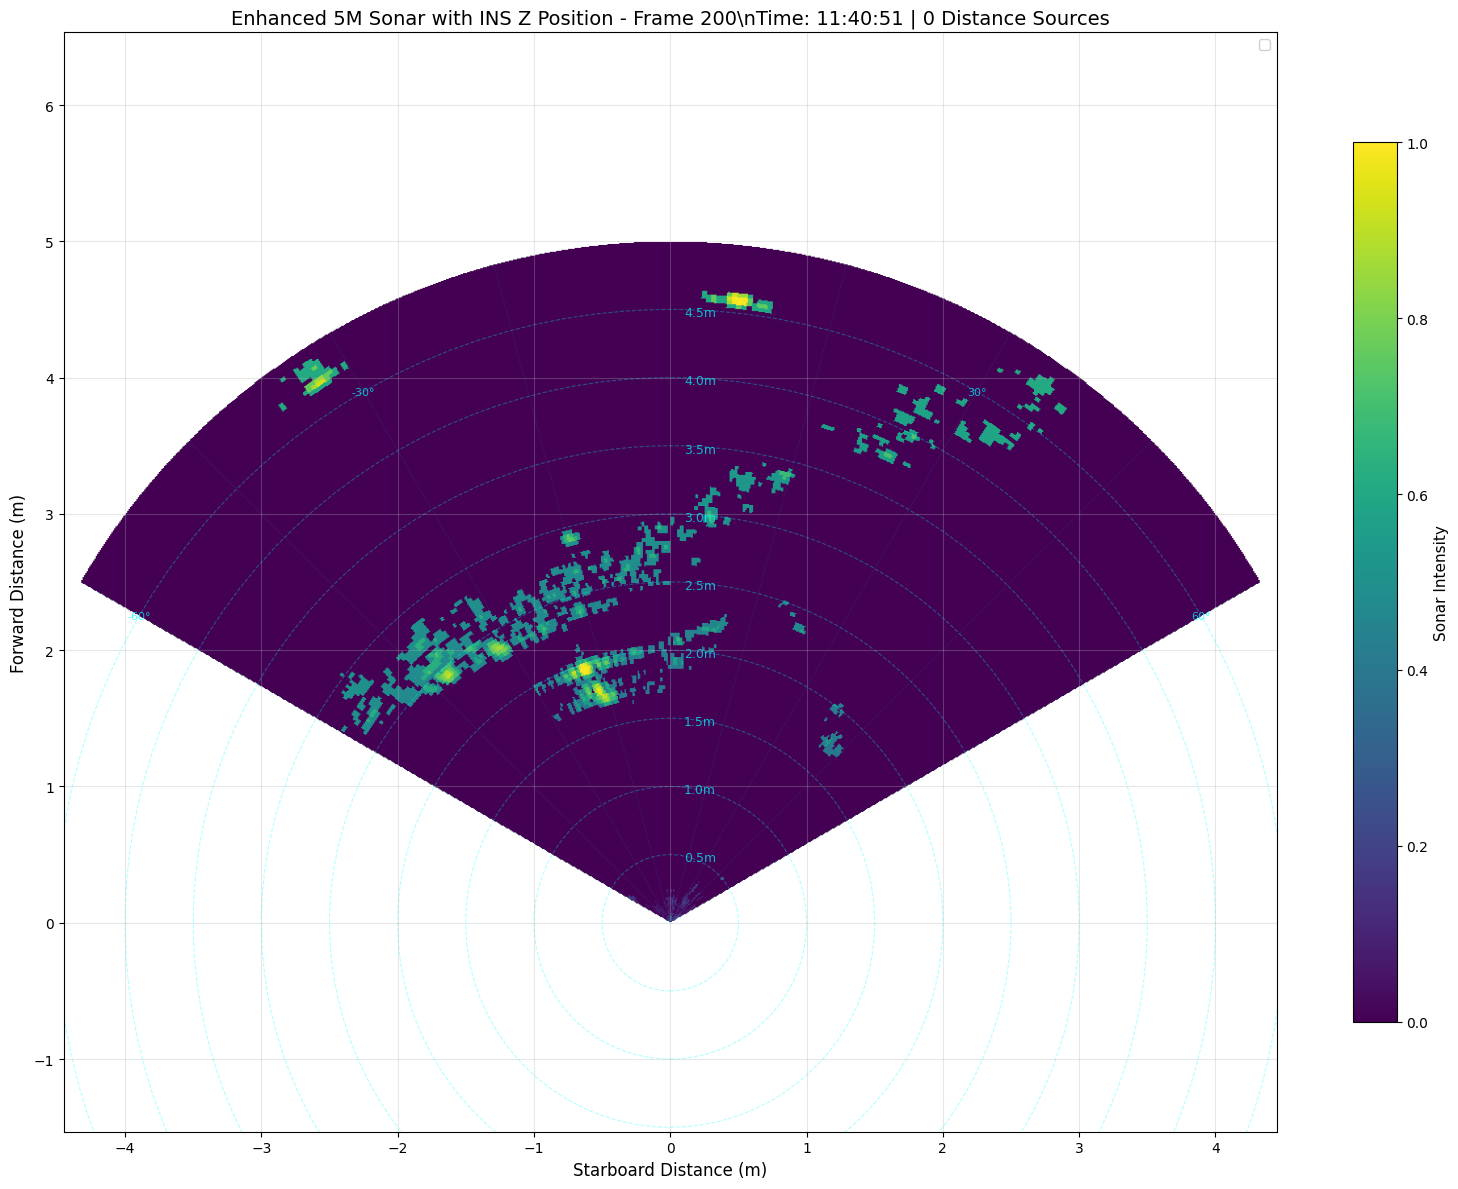

\n🔍 ENHANCED DISTANCE ANALYSIS WITH INS:
\n✅ Enhanced visualization with INS Z position complete!


In [22]:
# 🎯 ENHANCED VISUALIZATION WITH INS Z POSITION
# =============================================

print("🎯 CREATING ENHANCED VISUALIZATION WITH INS Z POSITION")
print("=" * 55)

import utils.sonar_utils as sonar_utils
from utils.sonar_utils import ConeGridSpec

# Generate enhanced single frame with INS Z position
target_bag = "2024-08-20_13-40-35"
sonar_csv_file = Path("/Users/eirikvarnes/code/SOLAQUA/exports/by_bag") / f"sensor_sonoptix_echo_image__{target_bag}_video.csv"

if sonar_csv_file.exists():
    print("📡 Processing enhanced frame with INS Z position...")
    
    # Load sonar CSV data
    sonar_df = pd.read_csv(sonar_csv_file)
    
    # Pick frame 50 as example
    frame_idx = 200
    
    if frame_idx < len(sonar_df):
        print(f"📊 Processing frame {frame_idx} with INS Z position...")
        
        # Configure 5m sonar processing
        sonar_params = {
            'fov_deg': 120,
            'rmin': 0.0,
            'rmax': 30.0,
            'y_zoom': 5.0,  # 5m range!
            'grid': ConeGridSpec(img_w=900, img_h=700),
            'enhanced': True
        }
        
        # Generate single frame
        try:
            # Get the raw sonar frame
            M = sonar_utils.get_sonoptix_frame(sonar_df, frame_idx)
            if M is not None:
                # Enhance and process
                Z = sonar_utils.enhance_intensity(M, sonar_params['rmin'], sonar_params['rmax'])
                cone, extent = sonar_utils.rasterize_cone(
                    Z, fov_deg=sonar_params['fov_deg'], 
                    rmin=sonar_params['rmin'], 
                    rmax=sonar_params['rmax'], 
                    y_zoom=sonar_params['y_zoom'], 
                    grid=sonar_params['grid']
                )
                
                # Get timestamp
                sonar_timestamp = pd.to_datetime(sonar_df.loc[frame_idx, 'ts_utc'])
                
                print(f"   🕐 Time: {sonar_timestamp.strftime('%H:%M:%S')}")
                print(f"   📐 Sonar extent: {extent}")
                
                # Collect all available distance measurements at this timestamp (including INS)
                distance_data = {}
                
                # 1. Navigation NetDistance (primary)
                if 'RAW_NAV_DATA' in globals() and RAW_NAV_DATA is not None:
                    time_diffs = abs(RAW_NAV_DATA['timestamp'] - sonar_timestamp)
                    nav_idx = time_diffs.idxmin()
                    if time_diffs.min() <= pd.Timedelta('1s'):
                        nav_distance = RAW_NAV_DATA.loc[nav_idx, 'NetDistance']
                        distance_data['Navigation NetDistance'] = {
                            'value': nav_distance,
                            'color': 'red',
                            'style': '-',
                            'width': 3,
                            'description': 'Primary navigation measurement'
                        }
                
                # 2. Guidance distances
                if 'RAW_GUIDANCE_DATA' in globals() and RAW_GUIDANCE_DATA is not None:
                    guidance_time_diffs = abs(RAW_GUIDANCE_DATA['timestamp'] - sonar_timestamp)
                    if guidance_time_diffs.min() <= pd.Timedelta('1s'):
                        guidance_idx = guidance_time_diffs.idxmin()
                        guidance_row = RAW_GUIDANCE_DATA.loc[guidance_idx]
                        
                        # Check for different guidance distance columns
                        if 'desired_net_distance' in guidance_row and pd.notna(guidance_row['desired_net_distance']):
                            distance_data['Desired Distance'] = {
                                'value': guidance_row['desired_net_distance'],
                                'color': 'green',
                                'style': ':',
                                'width': 2,
                                'description': 'Target/desired distance'
                            }
                        
                        if 'error_net_distance' in guidance_row and pd.notna(guidance_row['error_net_distance']):
                            distance_data['Guidance Error'] = {
                                'value': guidance_row['error_net_distance'],
                                'color': 'blue',
                                'style': '--',
                                'width': 2,
                                'description': 'Navigation error distance'
                            }
                
                # 3. All sensor measurements including new INS Z position
                if 'DISTANCE_MEASUREMENTS' in globals():
                    for dist_name, dist_info in DISTANCE_MEASUREMENTS.items():
                        dist_data = dist_info['data']
                        dist_col = dist_info['distance_col']
                        
                        # Find closest measurement within 2 seconds
                        dist_time_diffs = abs(dist_data['timestamp'] - sonar_timestamp)
                        if dist_time_diffs.min() <= pd.Timedelta('2s'):
                            dist_idx = dist_time_diffs.idxmin()
                            dist_row = dist_data.loc[dist_idx]
                            
                            if dist_col in dist_row and pd.notna(dist_row[dist_col]):
                                dist_val = dist_row[dist_col]
                                
                                # Special handling for INS Z position (might be negative depth)
                                if dist_name == 'INS_Z_Position':
                                    # For INS Z, we might want absolute value for distance visualization
                                    # or specific handling based on coordinate system
                                    if dist_val < 0:
                                        dist_val = abs(dist_val)  # Convert negative depth to positive distance
                                    
                                    distance_data[dist_name] = {
                                        'value': dist_val,
                                        'color': dist_info['color'],
                                        'style': '-',
                                        'width': 2,
                                        'description': f"{dist_info['description']} (abs value)"
                                    }
                                    
                                # Regular distance measurements (positive values only)
                                elif 0.1 <= dist_val <= 20.0:
                                    distance_data[dist_name] = {
                                        'value': dist_val,
                                        'color': dist_info['color'],
                                        'style': '-.',
                                        'width': 1.5,
                                        'description': dist_info['description']
                                    }
                
                print(f"\\n📏 Found {len(distance_data)} distance measurements (including INS):")
                for name, data in distance_data.items():
                    emoji = "🧭" if "INS" in name else "📏"
                    print(f"   {emoji} {name}: {data['value']:.3f}m ({data['description']})")
                
                # Create enhanced visualization
                plt.figure(figsize=(16, 12))
                
                # Show the sonar image
                im = plt.imshow(cone, extent=extent, cmap='viridis', origin='lower')
                
                # Add all distance lines with slight offsets to prevent overlap
                y_offset = 0.02  # Small vertical offset
                current_offset = 0
                
                for i, (name, data) in enumerate(distance_data.items()):
                    # Special highlighting for INS data
                    if "INS" in name:
                        line_alpha = 0.9
                        line_width = data['width'] + 0.5  # Make INS line slightly thicker
                    else:
                        line_alpha = 0.85
                        line_width = data['width']
                    
                    # Alternate offsets to spread lines
                    if i > 0:
                        current_offset = y_offset * (i % 3 - 1)  # -0.02, 0, +0.02, -0.02, 0, +0.02, ...
                    
                    plt.axhline(
                        y=data['value'] + current_offset, 
                        color=data['color'], 
                        linewidth=line_width,
                        linestyle=data['style'],
                        label=f"{'🧭 ' if 'INS' in name else ''}{name}: {data['value']:.3f}m",
                        alpha=line_alpha
                    )
                
                # Add range rings for reference
                range_rings = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
                for r in range_rings:
                    if r <= extent[3]:  # Don't exceed sonar range
                        circle = plt.Circle((0, 0), r, fill=False, color='cyan', alpha=0.3, linewidth=0.8, linestyle='--')
                        plt.gca().add_patch(circle)
                        plt.text(0.1, r-0.05, f'{r}m', color='cyan', fontsize=9, alpha=0.7)
                
                # Add polar grid lines for bearing reference
                angles = np.arange(-60, 61, 15)  # -60 to +60 degrees every 15 degrees
                for angle in angles:
                    if angle != 0:  # Skip center line
                        angle_rad = np.radians(angle)
                        x_end = extent[3] * np.sin(angle_rad)
                        y_end = extent[3] * np.cos(angle_rad)
                        plt.plot([0, x_end], [0, y_end], color='cyan', alpha=0.2, linewidth=0.5, linestyle=':')
                        if abs(angle) == 30 or abs(angle) == 60:  # Label major angles
                            plt.text(x_end*0.9, y_end*0.9, f'{angle}°', color='cyan', fontsize=8, alpha=0.7, 
                                    ha='center', va='center')
                
                # Formatting
                plt.xlabel('Starboard Distance (m)', fontsize=12)
                plt.ylabel('Forward Distance (m)', fontsize=12) 
                plt.title(f'Enhanced 5M Sonar with INS Z Position - Frame {frame_idx}\\nTime: {sonar_timestamp.strftime("%H:%M:%S")} | {len(distance_data)} Distance Sources', fontsize=14)
                
                # Create a more compact legend with special handling for INS
                legend = plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
                legend.get_frame().set_facecolor('white')
                
                plt.grid(True, alpha=0.3)
                
                # Add colorbar
                cbar = plt.colorbar(im, shrink=0.8)
                cbar.set_label('Sonar Intensity', fontsize=11)
                
                # Set equal aspect ratio for correct distance representation
                plt.axis('equal')
                plt.xlim(extent[0], extent[1])
                plt.ylim(extent[2], extent[3])
                
                plt.tight_layout()
                plt.show()
                
                # Enhanced analysis including INS
                print(f"\\n🔍 ENHANCED DISTANCE ANALYSIS WITH INS:")
                print(f"=" * 45)
                
                if distance_data:
                    distances = [data['value'] for data in distance_data.values()]
                    distance_names = list(distance_data.keys())
                    
                    print(f"📊 Range: {min(distances):.3f}m to {max(distances):.3f}m")
                    print(f"📊 Spread: {max(distances) - min(distances):.3f}m")
                    
                    # Special analysis for INS Z position
                    ins_measurements = {name: data for name, data in distance_data.items() if 'INS' in name}
                    if ins_measurements:
                        print(f"\\n🧭 INS Z POSITION ANALYSIS:")
                        for name, data in ins_measurements.items():
                            print(f"   • {name}: {data['value']:.3f}m")
                            print(f"     └─ {data['description']}")
                    
                    # Look for potential offsets/biases including INS
                    if 'Navigation NetDistance' in distance_data:
                        nav_dist = distance_data['Navigation NetDistance']['value']
                        print(f"\\n🎯 Comparison to Navigation NetDistance ({nav_dist:.3f}m):")
                        for name, data in distance_data.items():
                            if name != 'Navigation NetDistance':
                                offset = data['value'] - nav_dist
                                emoji = "🧭" if "INS" in name else "📏"
                                print(f"   {emoji} {name}: {data['value']:.3f}m (offset: {offset:+.3f}m)")
                    
                    # Identify measurements close to each other
                    print(f"\\n🔍 CLUSTERING ANALYSIS:")
                    close_pairs = []
                    for i, (name1, data1) in enumerate(distance_data.items()):
                        for j, (name2, data2) in enumerate(distance_data.items()):
                            if i < j:
                                diff = abs(data1['value'] - data2['value'])
                                if diff <= 0.1:  # Within 10cm
                                    close_pairs.append((name1, name2, diff))
                    
                    if close_pairs:
                        print(f"   📌 Measurements within 10cm of each other:")
                        for name1, name2, diff in close_pairs:
                            print(f"     • {name1} ↔ {name2}: {diff:.3f}m difference")
                    else:
                        print(f"   📌 No measurements within 10cm of each other")
                
                print(f"\\n✅ Enhanced visualization with INS Z position complete!")
                
            else:
                print(f"❌ Could not get sonar frame {frame_idx}")
                
        except Exception as e:
            print(f"❌ Error processing sonar frame: {e}")
            import traceback
            traceback.print_exc()
    
    else:
        print(f"❌ Frame {frame_idx} not available (only {len(sonar_df)} frames)")

else:
    print(f"❌ Sonar CSV file not found: {sonar_csv_file}")
    print("Please check the file path and try again.")

In [15]:
# 🔍 COMPREHENSIVE CSV SEARCH FOR NET-RELATED MEASUREMENTS
# ========================================================

print("🔍 SEARCHING ALL CSV FILES FOR NET/DISTANCE MEASUREMENTS")
print("=" * 60)

import glob
import os
from pathlib import Path

by_bag_folder = Path("/Users/eirikvarnes/code/SOLAQUA/exports/by_bag")
target_bag = "2024-08-22_14-29-05"  # Focus on our current bag

# Dictionary to store findings
findings = {
    'net_related': {},      # Files with 'net' in column names
    'distance_related': {}, # Files with 'distance' in column names  
    'depth_related': {},    # Files with 'depth' in column names
    'range_related': {},    # Files with 'range' in column names
    'position_related': {}, # Files with position/coordinate data
    'altitude_related': {}, # Files with altitude measurements
    'other_measurements': {} # Any other interesting measurement columns
}

# Search keywords for different types of measurements
search_keywords = {
    'net': ['net', 'Net', 'NET'],
    'distance': ['distance', 'Distance', 'DISTANCE', 'dist', 'Dist'],
    'depth': ['depth', 'Depth', 'DEPTH'],
    'range': ['range', 'Range', 'RANGE'],
    'position': ['x', 'y', 'z', 'X', 'Y', 'Z', 'position', 'Position', 'pos', 'east', 'north', 'lat', 'lon'],
    'altitude': ['altitude', 'Altitude', 'ALT', 'alt', 'height', 'Height'],
    'measurement': ['measurement', 'Measurement', 'value', 'Value', 'reading', 'Reading']
}

print(f"📁 Scanning {by_bag_folder}")
print(f"🎯 Focusing on bag: {target_bag}")
print()

# Get all CSV files for our target bag
csv_files = list(by_bag_folder.glob(f"*{target_bag}*.csv"))
print(f"📊 Found {len(csv_files)} CSV files for target bag")
print()

# Process each file
for csv_file in sorted(csv_files):
    file_name = csv_file.name
    topic_name = file_name.replace(f"__{target_bag}_data.csv", "").replace(f"__{target_bag}_video.csv", "")
    
    try:
        # Just read the header to get column names (fast)
        df_sample = pd.read_csv(csv_file, nrows=0)
        columns = df_sample.columns.tolist()
        
        # Skip if no interesting columns
        if len(columns) <= 2:  # Usually just timestamp columns
            continue
            
        print(f"📋 {topic_name}:")
        print(f"   File: {file_name}")
        print(f"   Columns ({len(columns)}): {columns}")
        
        # Search for different types of measurements
        found_categories = []
        
        # Check for net-related columns
        net_cols = [col for col in columns if any(keyword in col for keyword in search_keywords['net'])]
        if net_cols:
            findings['net_related'][topic_name] = {
                'file': csv_file,
                'columns': net_cols,
                'all_columns': columns
            }
            found_categories.append(f"🎯 NET: {net_cols}")
        
        # Check for distance-related columns
        dist_cols = [col for col in columns if any(keyword in col for keyword in search_keywords['distance'])]
        if dist_cols:
            findings['distance_related'][topic_name] = {
                'file': csv_file,
                'columns': dist_cols,
                'all_columns': columns
            }
            found_categories.append(f"📏 DISTANCE: {dist_cols}")
        
        # Check for depth-related columns
        depth_cols = [col for col in columns if any(keyword in col for keyword in search_keywords['depth'])]
        if depth_cols:
            findings['depth_related'][topic_name] = {
                'file': csv_file,
                'columns': depth_cols,
                'all_columns': columns
            }
            found_categories.append(f"🌊 DEPTH: {depth_cols}")
        
        # Check for range-related columns
        range_cols = [col for col in columns if any(keyword in col for keyword in search_keywords['range'])]
        if range_cols:
            findings['range_related'][topic_name] = {
                'file': csv_file,
                'columns': range_cols,
                'all_columns': columns
            }
            found_categories.append(f"📐 RANGE: {range_cols}")
        
        # Check for position-related columns
        pos_cols = [col for col in columns if any(keyword in col for keyword in search_keywords['position'])]
        if pos_cols:
            findings['position_related'][topic_name] = {
                'file': csv_file,
                'columns': pos_cols,
                'all_columns': columns
            }
            found_categories.append(f"📍 POSITION: {pos_cols}")
        
        # Check for altitude-related columns
        alt_cols = [col for col in columns if any(keyword in col for keyword in search_keywords['altitude'])]
        if alt_cols:
            findings['altitude_related'][topic_name] = {
                'file': csv_file,
                'columns': alt_cols,
                'all_columns': columns
            }
            found_categories.append(f"⛰️ ALTITUDE: {alt_cols}")
        
        # Check for other measurement columns
        measurement_cols = [col for col in columns if any(keyword in col for keyword in search_keywords['measurement'])]
        # Exclude already found columns
        other_measurement_cols = [col for col in measurement_cols 
                                 if col not in net_cols + dist_cols + depth_cols + range_cols + pos_cols + alt_cols]
        if other_measurement_cols:
            findings['other_measurements'][topic_name] = {
                'file': csv_file,
                'columns': other_measurement_cols,
                'all_columns': columns
            }
            found_categories.append(f"📊 OTHER: {other_measurement_cols}")
        
        # Display findings for this file
        if found_categories:
            for category in found_categories:
                print(f"   {category}")
        else:
            print(f"   ⚪ No relevant measurements found")
        
        print()
        
    except Exception as e:
        print(f"   ❌ Error reading {file_name}: {e}")
        print()

print(f"\n🎯 SEARCH SUMMARY")
print(f"=" * 40)

# Summary of findings
total_files_with_findings = 0
for category, files in findings.items():
    if files:
        total_files_with_findings += len(files)
        print(f"\n{category.upper().replace('_', ' ')} ({len(files)} files):")
        for topic, info in files.items():
            print(f"   📋 {topic}: {info['columns']}")

print(f"\n📊 STATISTICS:")
print(f"   Total files scanned: {len(csv_files)}")
print(f"   Files with relevant measurements: {total_files_with_findings}")
print(f"   Net-related topics: {len(findings['net_related'])}")
print(f"   Distance-related topics: {len(findings['distance_related'])}")
print(f"   Depth-related topics: {len(findings['depth_related'])}")
print(f"   Range-related topics: {len(findings['range_related'])}")
print(f"   Position-related topics: {len(findings['position_related'])}")
print(f"   Altitude-related topics: {len(findings['altitude_related'])}")

# Store findings globally for further analysis
MEASUREMENT_FINDINGS = findings

print(f"\n✅ Comprehensive CSV search complete!")
print(f"📝 Results stored in MEASUREMENT_FINDINGS variable")

🔍 SEARCHING ALL CSV FILES FOR NET/DISTANCE MEASUREMENTS
📁 Scanning /Users/eirikvarnes/code/SOLAQUA/exports/by_bag
🎯 Focusing on bag: 2024-08-22_14-29-05

📊 Found 31 CSV files for target bag

📋 bluerov2_alive:
   File: bluerov2_alive__2024-08-22_14-29-05_data.csv
   Columns (13): ['t', 't_header', 't_bag', 't_src', 'bag', 'bag_file', 'topic', 'data', '__msgtype__', 't0', 't_rel', 'ts_utc', 'ts_oslo']
   📍 POSITION: ['__msgtype__']

📋 bluerov2_armed:
   File: bluerov2_armed__2024-08-22_14-29-05_data.csv
   Columns (13): ['t', 't_header', 't_bag', 't_src', 'bag', 'bag_file', 'topic', 'data', '__msgtype__', 't0', 't_rel', 'ts_utc', 'ts_oslo']
   📍 POSITION: ['__msgtype__']

📋 bluerov2_battery:
   File: bluerov2_battery__2024-08-22_14-29-05_data.csv
   Columns (15): ['t', 't_header', 't_bag', 't_src', 'bag', 'bag_file', 'topic', 'current_battery', 'current_consumed', 'voltage', '__msgtype__', 't0', 't_rel', 'ts_utc', 'ts_oslo']
   📍 POSITION: ['current_battery', '__msgtype__']

📋 bluerov2_m

In [16]:
# 🎯 FOCUSED ANALYSIS OF NET-RELATED MEASUREMENTS
# ===============================================

print("🎯 DETAILED ANALYSIS OF NET-RELATED FINDINGS")
print("=" * 45)

if 'MEASUREMENT_FINDINGS' in globals():
    
    # 1. NET-RELATED MEASUREMENTS (Highest Priority)
    print("🔴 NET-RELATED MEASUREMENTS:")
    print("-" * 30)
    if MEASUREMENT_FINDINGS['net_related']:
        for topic, info in MEASUREMENT_FINDINGS['net_related'].items():
            print(f"📋 {topic}:")
            print(f"   📁 File: {info['file'].name}")
            print(f"   🎯 Net columns: {info['columns']}")
            print(f"   📊 All columns: {info['all_columns']}")
            
            # Try to load sample data to see what's in these columns
            try:
                sample_df = pd.read_csv(info['file'], nrows=5)
                print(f"   📝 Sample data:")
                for col in info['columns']:
                    if col in sample_df.columns:
                        values = sample_df[col].dropna()
                        if len(values) > 0:
                            print(f"      {col}: {values.tolist()}")
                        else:
                            print(f"      {col}: [no data in sample]")
            except Exception as e:
                print(f"   ❌ Error loading sample: {e}")
            print()
    else:
        print("   ⚪ No files with 'net' in column names found")
    
    # 2. DISTANCE-RELATED MEASUREMENTS
    print("\n📏 DISTANCE-RELATED MEASUREMENTS:")
    print("-" * 35)
    if MEASUREMENT_FINDINGS['distance_related']:
        distance_topics = list(MEASUREMENT_FINDINGS['distance_related'].keys())
        print(f"   Found in {len(distance_topics)} topics: {distance_topics}")
        
        # Show the most promising ones
        for topic, info in list(MEASUREMENT_FINDINGS['distance_related'].items())[:3]:  # Show first 3
            print(f"\n   📋 {topic}:")
            print(f"      🎯 Distance columns: {info['columns']}")
            
            # Check if these might be net-related even without 'net' in the name
            net_like_cols = [col for col in info['columns'] 
                           if any(keyword in col.lower() for keyword in ['net', 'target', 'object', 'obstacle'])]
            if net_like_cols:
                print(f"      🚨 Potentially net-related: {net_like_cols}")
    else:
        print("   ⚪ No distance-related columns found")
    
    # 3. GUI NET FOLLOWING MANAGER (Very Promising!)
    print("\n🎮 GUI NET FOLLOWING MANAGER:")
    print("-" * 30)
    gui_net_topics = [topic for topic in MEASUREMENT_FINDINGS.get('other_measurements', {}).keys() 
                     if 'gui_netFollowing' in topic]
    
    if not gui_net_topics:
        # Check if it's in other categories
        for category, topics in MEASUREMENT_FINDINGS.items():
            gui_net_topics.extend([topic for topic in topics.keys() if 'gui_netFollowing' in topic])
    
    if gui_net_topics:
        print(f"   🎯 Found GUI Net Following topics: {gui_net_topics}")
        
        # Examine the gui_netFollowing_manager file specifically
        gui_file = by_bag_folder / f"gui_netFollowing_manager__{target_bag}_data.csv"
        if gui_file.exists():
            try:
                print(f"\n   📋 Examining: {gui_file.name}")
                
                # Load header and sample data
                gui_df = pd.read_csv(gui_file, nrows=10)
                print(f"   📊 Columns ({len(gui_df.columns)}): {list(gui_df.columns)}")
                
                # Look for measurement columns
                measurement_cols = [col for col in gui_df.columns 
                                  if not col.startswith('ts_') and col not in ['timestamp']]
                
                if measurement_cols:
                    print(f"   🎯 Measurement columns: {measurement_cols}")
                    
                    # Show sample values for each measurement column
                    print(f"   📝 Sample data:")
                    for col in measurement_cols:
                        values = gui_df[col].dropna()
                        if len(values) > 0:
                            if values.dtype in ['float64', 'int64']:
                                print(f"      {col}: {values.min():.3f} to {values.max():.3f} (mean: {values.mean():.3f})")
                            else:
                                print(f"      {col}: {values.unique()[:5].tolist()}")
                        else:
                            print(f"      {col}: [no data]")
                            
            except Exception as e:
                print(f"   ❌ Error examining GUI file: {e}")
    else:
        print("   ⚪ No GUI Net Following topics found")
    
    # 4. PING360 SENSOR (Another potential source)
    print("\n📡 PING360 SENSOR DATA:")
    print("-" * 25)
    ping_topics = [topic for topic in MEASUREMENT_FINDINGS.get('range_related', {}).keys() 
                  if 'ping360' in topic]
    
    if not ping_topics:
        # Check all categories for ping360
        for category, topics in MEASUREMENT_FINDINGS.items():
            ping_topics.extend([topic for topic in topics.keys() if 'ping360' in topic])
    
    if ping_topics:
        print(f"   🎯 Found Ping360 topics: {ping_topics}")
        
        # Check the ping360 files
        ping_files = [f for f in csv_files if 'ping360' in f.name and target_bag in f.name]
        for ping_file in ping_files:
            try:
                print(f"\n   📋 Examining: {ping_file.name}")
                ping_df = pd.read_csv(ping_file, nrows=5)
                
                # Look for distance/range measurements
                distance_cols = [col for col in ping_df.columns 
                               if any(keyword in col.lower() for keyword in ['distance', 'range', 'measurement'])]
                
                print(f"   📊 Potential distance columns: {distance_cols}")
                if distance_cols:
                    for col in distance_cols:
                        values = ping_df[col].dropna()
                        if len(values) > 0:
                            print(f"      {col}: {values.tolist()}")
                            
            except Exception as e:
                print(f"   ❌ Error examining {ping_file.name}: {e}")
    else:
        print("   ⚪ No Ping360 topics found")
    
    print(f"\n✅ Detailed analysis complete!")
    print(f"🔍 Check the output above for potential new net distance sources")

else:
    print("❌ MEASUREMENT_FINDINGS not found. Please run the search cell first.")

🎯 DETAILED ANALYSIS OF NET-RELATED FINDINGS
🔴 NET-RELATED MEASUREMENTS:
------------------------------
📋 gui_netFollowing_manager:
   📁 File: gui_netFollowing_manager__2024-08-22_14-29-05_data.csv
   🎯 Net columns: ['d_net_distance', 'd_net_velocity_horizontal', 'd_net_velocity_vertical', 'offset_net_heading']
   📊 All columns: ['t', 't_header', 't_bag', 't_src', 'bag', 'bag_file', 'topic', 'd_depth', 'd_net_distance', 'd_net_velocity_horizontal', 'd_net_velocity_vertical', 'offset_net_heading', '__msgtype__', 't0', 't_rel', 'ts_utc', 'ts_oslo']
   📝 Sample data:
      d_net_distance: [0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579]
      d_net_velocity_horizontal: [-0.1000000014901161, -0.1000000014901161, -0.1000000014901161, -0.1000000014901161, -0.1000000014901161]
      d_net_velocity_vertical: [0.0, 0.0, 0.0, 0.0, 0.0]
      offset_net_heading: [0.0, 0.0, 0.0, 0.0, 0.0]

📋 guidance:
   📁 File: guidance__2024-08-22_14-29-05_data.

In [17]:
# 🧭 ADD INS Z POSITION TO VISUALIZATION
# =====================================

print("🧭 LOADING INS DATA AND ENHANCING VISUALIZATION")
print("=" * 50)

# Load INS data for the target bag
target_bag = "2024-08-22_14-29-05"
ins_file = Path("/Users/eirikvarnes/code/SOLAQUA/exports/by_bag") / f"nucleus1000dvl_ins__{target_bag}_data.csv"

if ins_file.exists():
    print(f"📡 Loading INS data from: {ins_file.name}")
    
    # Load INS data
    ins_data = pd.read_csv(ins_file)
    ins_data['timestamp'] = pd.to_datetime(ins_data['ts_utc'])
    
    print(f"   ✅ Loaded {len(ins_data)} INS records")
    print(f"   📊 Available columns: {list(ins_data.columns)}")
    
    # Check for z position columns
    z_cols = [col for col in ins_data.columns if 'z' in col.lower() and ('pos' in col.lower() or 'position' in col.lower() or col.lower() == 'z')]
    depth_cols = [col for col in ins_data.columns if 'depth' in col.lower()]
    altitude_cols = [col for col in ins_data.columns if 'alt' in col.lower()]
    
    print(f"   🔍 Z position columns: {z_cols}")
    print(f"   🔍 Depth columns: {depth_cols}")
    print(f"   🔍 Altitude columns: {altitude_cols}")
    
    # Find the best Z position column
    z_position_col = None
    if z_cols:
        z_position_col = z_cols[0]  # Use first z position column
    elif depth_cols:
        z_position_col = depth_cols[0]  # Use depth as fallback
    elif altitude_cols:
        z_position_col = altitude_cols[0]  # Use altitude as fallback
    
    if z_position_col:
        # Check for valid z position values
        z_values = ins_data[z_position_col].dropna()
        if len(z_values) > 0:
            print(f"   📏 Using column: {z_position_col}")
            print(f"   📏 Z position range: {z_values.min():.3f} to {z_values.max():.3f}m")
            print(f"   📊 Z position mean: {z_values.mean():.3f} ± {z_values.std():.3f}m")
            
            # Add to DISTANCE_MEASUREMENTS for inclusion in visualizations
            if 'DISTANCE_MEASUREMENTS' in globals():
                DISTANCE_MEASUREMENTS['INS_Z_Position'] = {
                    'data': ins_data,
                    'distance_col': z_position_col,
                    'description': f'INS {z_position_col} (vertical position)',
                    'color': 'darkblue'
                }
                print(f"   ✅ Added INS Z position to distance measurements")
            else:
                print(f"   ⚠️  DISTANCE_MEASUREMENTS not available")
        else:
            print(f"   ❌ No valid values in {z_position_col}")
    else:
        print(f"   ❌ No Z position columns found")
        
    # Show sample of INS data
    print(f"\\n📊 Sample INS data:")
    print(ins_data.head()[['timestamp'] + [col for col in ins_data.columns if col != 'ts_utc'][:8]].to_string())
    
else:
    print(f"❌ INS file not found: {ins_file}")

print(f"\\n🧭 INS data loading complete!")

🧭 LOADING INS DATA AND ENHANCING VISUALIZATION
📡 Loading INS data from: nucleus1000dvl_ins__2024-08-22_14-29-05_data.csv
   ✅ Loaded 562 INS records
   📊 Available columns: ['t', 't_header', 't_bag', 't_src', 'bag', 'bag_file', 'topic', 'operation_mode', 'fomAhrs', 'fomFc1', 'ahrsData', 'quaternion.x', 'quaternion.y', 'quaternion.z', 'quaternion.w', 'quaternion.__msgtype__', 'declination', 'depth', 'fomIns', 'courseOverGround', 'speedOverGround', 'temperature', 'pressure', 'altitude', 'latitude', 'longitude', 'latLonIsValid', 'positionFrame.x', 'positionFrame.y', 'positionFrame.z', 'positionFrame.__msgtype__', 'velocityNed.x', 'velocityNed.y', 'velocityNed.z', 'velocityNed.__msgtype__', 'velocityNucleus.x', 'velocityNucleus.y', 'velocityNucleus.z', 'velocityNucleus.__msgtype__', 'turnRate.x', 'turnRate.y', 'turnRate.z', 'turnRate.__msgtype__', '__msgtype__', 't0', 't_rel', 'ts_utc', 'ts_oslo', 'timestamp']
   🔍 Z position columns: ['positionFrame.z']
   🔍 Depth columns: ['depth']
   🔍 

🎯 CREATING ENHANCED VISUALIZATION WITH INS Z POSITION
📡 Processing enhanced frame with INS Z position...


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_98464/3095137377.py:217: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


📊 Processing frame 500 with INS Z position...
   🕐 Time: 12:29:39
   📐 Sonar extent: (np.float64(-4.330127018922193), np.float64(4.330127018922193), 0.0, 5.0)
\n📏 Found 7 distance measurements (including INS):
   📏 Navigation NetDistance: 0.570m (Primary navigation measurement)
   📏 Desired Distance: 0.600m (Target/desired distance)
   📏 Guidance Error: -0.030m (Navigation error distance)
   📏 USBL_3D: 7.563m (3D acoustic position)
   📏 DVL_Position: 2.888m (3D DVL position)
   📏 Nav_Position: 2.883m (2D navigation position)
   🧭 INS_Z_Position: 2.228m (INS positionFrame.z (vertical position) (abs value))


/Users/eirikvarnes/code/SOLAQUA/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


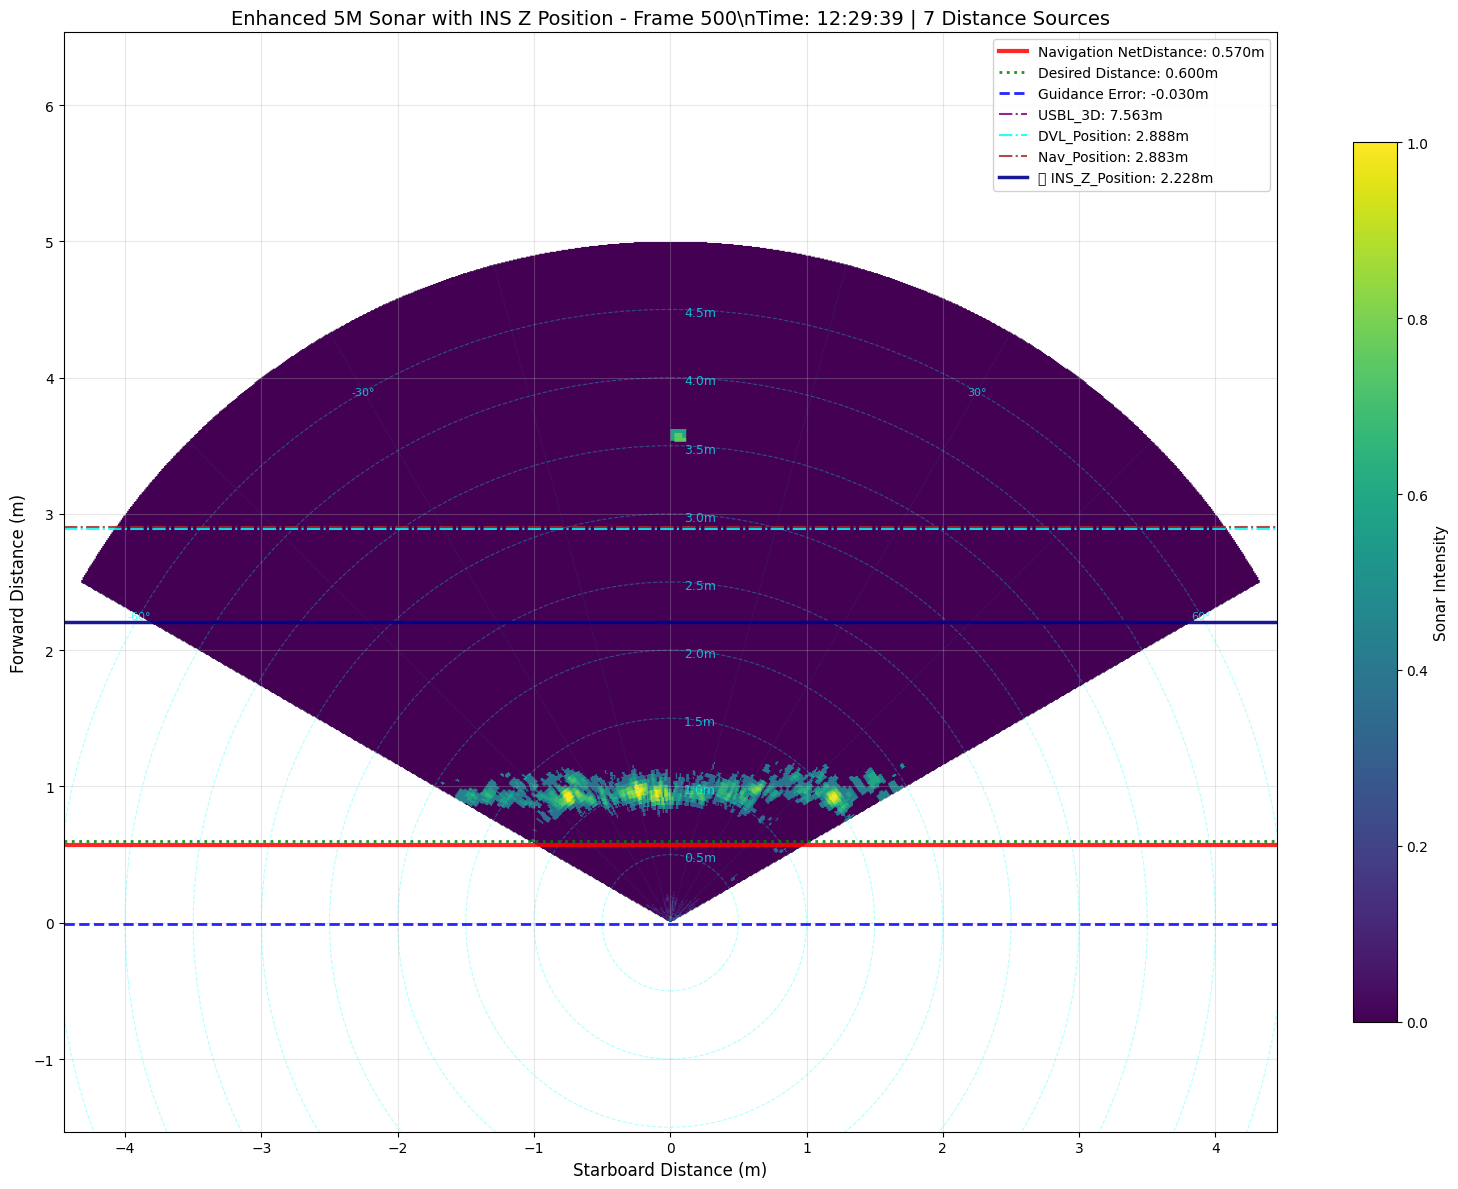

\n🔍 ENHANCED DISTANCE ANALYSIS WITH INS:
📊 Range: -0.030m to 7.563m
📊 Spread: 7.593m
\n🧭 INS Z POSITION ANALYSIS:
   • INS_Z_Position: 2.228m
     └─ INS positionFrame.z (vertical position) (abs value)
\n🎯 Comparison to Navigation NetDistance (0.570m):
   📏 Desired Distance: 0.600m (offset: +0.030m)
   📏 Guidance Error: -0.030m (offset: -0.600m)
   📏 USBL_3D: 7.563m (offset: +6.993m)
   📏 DVL_Position: 2.888m (offset: +2.318m)
   📏 Nav_Position: 2.883m (offset: +2.313m)
   🧭 INS_Z_Position: 2.228m (offset: +1.658m)
\n🔍 CLUSTERING ANALYSIS:
   📌 Measurements within 10cm of each other:
     • Navigation NetDistance ↔ Desired Distance: 0.030m difference
     • DVL_Position ↔ Nav_Position: 0.005m difference
\n✅ Enhanced visualization with INS Z position complete!


In [ ]:
# 🎛️ CENTRALIZED BAG CONFIGURATION AND DATA LOADING
# ==================================================

def load_all_distance_data_for_bag(target_bag):
    """
    Load all distance measurement data for a specific bag.
    This function centralizes data loading to ensure consistency when changing bags.
    """
    
    print(f"🎯 LOADING ALL DISTANCE DATA FOR BAG: {target_bag}")
    print("=" * 60)
    
    data_folder = Path("/Users/eirikvarnes/code/SOLAQUA/exports")
    distance_measurements = {}
    raw_data = {}
    
    # 1. Load Navigation Data
    print("📡 1. Loading Navigation Data...")
    try:
        nav_file = data_folder / "by_bag" / f"navigation_plane_approximation__{target_bag}_data.csv"
        if nav_file.exists():
            nav_data = pd.read_csv(nav_file, usecols=['ts_oslo', 'NetDistance', 'Altitude'])
            nav_data['timestamp'] = pd.to_datetime(nav_data['ts_oslo']).dt.tz_convert('UTC')
            nav_data['net_distance_m_raw'] = nav_data['NetDistance']
            raw_data['navigation'] = nav_data[['timestamp', 'net_distance_m_raw', 'NetDistance', 'Altitude']].copy()
            print(f"   ✅ Loaded {len(nav_data)} navigation records")
        else:
            print(f"   ❌ Navigation file not found")
            raw_data['navigation'] = None
    except Exception as e:
        print(f"   ❌ Error loading navigation: {e}")
        raw_data['navigation'] = None
    
    # 2. Load Guidance Data  
    print("📡 2. Loading Guidance Data...")
    try:
        guidance_file = data_folder / "by_bag" / f"guidance__{target_bag}_data.csv"
        if guidance_file.exists():
            guidance_data = pd.read_csv(guidance_file)
            guidance_data['timestamp'] = pd.to_datetime(guidance_data['ts_oslo']).dt.tz_convert('UTC')
            distance_cols = [col for col in guidance_data.columns if 'distance' in col.lower()]
            if distance_cols:
                raw_data['guidance'] = guidance_data[['timestamp'] + distance_cols].copy()
                print(f"   ✅ Loaded {len(guidance_data)} guidance records with {distance_cols}")
            else:
                raw_data['guidance'] = None
                print(f"   ⚠️  No distance columns in guidance data")
        else:
            print(f"   ❌ Guidance file not found")
            raw_data['guidance'] = None
    except Exception as e:
        print(f"   ❌ Error loading guidance: {e}")
        raw_data['guidance'] = None
    
    # 3. Load DVL Altimeter
    print("📡 3. Loading DVL Altimeter...")
    try:
        dvl_alt_file = data_folder / "by_bag" / f"nucleus1000dvl_altimeter__{target_bag}_data.csv"
        if dvl_alt_file.exists():
            dvl_alt = pd.read_csv(dvl_alt_file)
            dvl_alt['timestamp'] = pd.to_datetime(dvl_alt['ts_utc'])
            if 'altimeter_distance' in dvl_alt.columns:
                distance_measurements['DVL_Altimeter'] = {
                    'data': dvl_alt,
                    'distance_col': 'altimeter_distance',
                    'description': 'Distance to seafloor',
                    'color': 'orange'
                }
                print(f"   ✅ Loaded {len(dvl_alt)} DVL altimeter records")
            else:
                print(f"   ⚠️  No altimeter_distance column")
        else:
            print(f"   ❌ DVL altimeter file not found")
    except Exception as e:
        print(f"   ❌ Error loading DVL altimeter: {e}")
    
    # 4. Load USBL
    print("📡 4. Loading USBL...")
    try:
        usbl_file = data_folder / "by_bag" / f"sensor_usbl__{target_bag}_data.csv"
        if usbl_file.exists():
            usbl = pd.read_csv(usbl_file)
            usbl['timestamp'] = pd.to_datetime(usbl['ts_utc'])
            if all(col in usbl.columns for col in ['east', 'north', 'depth']):
                usbl['usbl_distance'] = np.sqrt(usbl['east']**2 + usbl['north']**2 + usbl['depth']**2)
                distance_measurements['USBL_3D'] = {
                    'data': usbl,
                    'distance_col': 'usbl_distance',
                    'description': '3D acoustic position',
                    'color': 'purple'
                }
                distance_measurements['USBL_Depth'] = {
                    'data': usbl,
                    'distance_col': 'depth',
                    'description': 'USBL depth measurement',
                    'color': 'magenta'
                }
                print(f"   ✅ Loaded {len(usbl)} USBL records")
            else:
                print(f"   ⚠️  Missing USBL position columns")
        else:
            print(f"   ❌ USBL file not found")
    except Exception as e:
        print(f"   ❌ Error loading USBL: {e}")
    
    # 5. Load DVL Position
    print("📡 5. Loading DVL Position...")
    try:
        dvl_pos_file = data_folder / "by_bag" / f"sensor_dvl_position__{target_bag}_data.csv"
        if dvl_pos_file.exists():
            dvl_pos = pd.read_csv(dvl_pos_file)
            dvl_pos['timestamp'] = pd.to_datetime(dvl_pos['ts_utc'])
            if all(col in dvl_pos.columns for col in ['x', 'y', 'z']):
                dvl_pos['dvl_3d_distance'] = np.sqrt(dvl_pos['x']**2 + dvl_pos['y']**2 + dvl_pos['z']**2)
                distance_measurements['DVL_Position'] = {
                    'data': dvl_pos,
                    'distance_col': 'dvl_3d_distance',
                    'description': '3D DVL position',
                    'color': 'cyan'
                }
                print(f"   ✅ Loaded {len(dvl_pos)} DVL position records")
            else:
                print(f"   ⚠️  Missing DVL position columns")
        else:
            print(f"   ❌ DVL position file not found")
    except Exception as e:
        print(f"   ❌ Error loading DVL position: {e}")
    
    # 6. Load Navigation Position
    print("📡 6. Loading Navigation Position...")
    try:
        nav_pos_file = data_folder / "by_bag" / f"navigation_plane_approximation_position__{target_bag}_data.csv"
        if nav_pos_file.exists():
            nav_pos = pd.read_csv(nav_pos_file)
            nav_pos['timestamp'] = pd.to_datetime(nav_pos['ts_utc'])
            if all(col in nav_pos.columns for col in ['x', 'y']):
                nav_pos['nav_2d_distance'] = np.sqrt(nav_pos['x']**2 + nav_pos['y']**2)
                distance_measurements['Nav_Position'] = {
                    'data': nav_pos,
                    'distance_col': 'nav_2d_distance',
                    'description': '2D navigation position',
                    'color': 'brown'
                }
                print(f"   ✅ Loaded {len(nav_pos)} navigation position records")
            else:
                print(f"   ⚠️  Missing navigation position columns")
        else:
            print(f"   ❌ Navigation position file not found")
    except Exception as e:
        print(f"   ❌ Error loading navigation position: {e}")
    
    # 7. Load INS Z Position
    print("📡 7. Loading INS Z Position...")
    try:
        ins_file = data_folder / "by_bag" / f"nucleus1000dvl_ins__{target_bag}_data.csv"
        if ins_file.exists():
            ins_data = pd.read_csv(ins_file)
            ins_data['timestamp'] = pd.to_datetime(ins_data['ts_utc'])
            
            # Find z position column
            z_cols = [col for col in ins_data.columns if 'z' in col.lower() and ('pos' in col.lower() or 'position' in col.lower() or col.lower() == 'z')]
            depth_cols = [col for col in ins_data.columns if 'depth' in col.lower()]
            altitude_cols = [col for col in ins_data.columns if 'alt' in col.lower()]
            
            z_position_col = None
            if z_cols:
                z_position_col = z_cols[0]
            elif depth_cols:
                z_position_col = depth_cols[0]
            elif altitude_cols:
                z_position_col = altitude_cols[0]
            
            if z_position_col:
                z_values = ins_data[z_position_col].dropna()
                if len(z_values) > 0:
                    distance_measurements['INS_Z_Position'] = {
                        'data': ins_data,
                        'distance_col': z_position_col,
                        'description': f'INS {z_position_col} (vertical position)',
                        'color': 'darkblue'
                    }
                    print(f"   ✅ Loaded {len(ins_data)} INS records with {z_position_col}")
                else:
                    print(f"   ⚠️  No valid {z_position_col} values")
            else:
                print(f"   ⚠️  No Z position columns found")
        else:
            print(f"   ❌ INS file not found")
    except Exception as e:
        print(f"   ❌ Error loading INS: {e}")
    
    # Summary
    print(f"\\n📊 LOADING SUMMARY:")
    print(f"   🎯 Target bag: {target_bag}")
    print(f"   📁 Raw data loaded: {len([k for k, v in raw_data.items() if v is not None])}/{len(raw_data)}")
    print(f"   📏 Distance measurements: {len(distance_measurements)}")
    
    return raw_data, distance_measurements

# 🎛️ CONFIGURATION SECTION - CHANGE BAG HERE
# ===========================================
# **CHANGE THIS VARIABLE TO SWITCH BAGS**
CURRENT_BAG = "2024-08-22_14-29-05"

print(f"🎛️ CURRENT BAG CONFIGURATION: {CURRENT_BAG}")
print("🔄 To change bag, modify CURRENT_BAG variable above and re-run this cell")
print()

# Load all data for current bag
RAW_DATA_ALL, DISTANCE_MEASUREMENTS_ALL = load_all_distance_data_for_bag(CURRENT_BAG)

# Set global variables for compatibility with existing code
RAW_NAV_DATA = RAW_DATA_ALL['navigation']
RAW_GUIDANCE_DATA = RAW_DATA_ALL['guidance'] 
DISTANCE_MEASUREMENTS = DISTANCE_MEASUREMENTS_ALL

print(f"\\n✅ All data loaded for bag: {CURRENT_BAG}")
print(f"📍 Global variables updated: RAW_NAV_DATA, RAW_GUIDANCE_DATA, DISTANCE_MEASUREMENTS")
print(f"🔄 Re-run visualization cells to see updated data!")

In [ ]:
# 🎯 BAG-AWARE SONAR VISUALIZATION 
# ================================

def create_sonar_visualization_for_current_bag(frame_idx=500):
    """
    Create sonar visualization using the currently loaded bag data.
    Automatically adapts to whatever bag is set in CURRENT_BAG.
    """
    
    print(f"🎯 CREATING SONAR VISUALIZATION FOR BAG: {CURRENT_BAG}")
    print(f"📊 Frame: {frame_idx}")
    print("=" * 50)
    
    import utils.sonar_utils as sonar_utils
    from utils.sonar_utils import ConeGridSpec
    
    # Build sonar file path for current bag
    sonar_csv_file = Path("/Users/eirikvarnes/code/SOLAQUA/exports/by_bag") / f"sensor_sonoptix_echo_image__{CURRENT_BAG}_video.csv"
    
    if not sonar_csv_file.exists():
        print(f"❌ Sonar CSV file not found for bag {CURRENT_BAG}")
        print(f"   Expected: {sonar_csv_file}")
        return
    
    # Load sonar data for current bag
    sonar_df = pd.read_csv(sonar_csv_file)
    print(f"📡 Loaded {len(sonar_df)} sonar frames for bag {CURRENT_BAG}")
    
    if frame_idx >= len(sonar_df):
        print(f"❌ Frame {frame_idx} not available (only {len(sonar_df)} frames)")
        print(f"   Adjusting to last available frame: {len(sonar_df)-1}")
        frame_idx = len(sonar_df) - 1
    
    try:
        # Configure 5m sonar processing
        sonar_params = {
            'fov_deg': 120,
            'rmin': 0.0,
            'rmax': 30.0,
            'y_zoom': 5.0,  # 5m range!
            'grid': ConeGridSpec(img_w=900, img_h=700),
            'enhanced': True
        }
        
        # Get the raw sonar frame
        M = sonar_utils.get_sonoptix_frame(sonar_df, frame_idx)
        if M is None:
            print(f"❌ Could not get sonar frame {frame_idx}")
            return
        
        # Enhance and process
        Z = sonar_utils.enhance_intensity(M, sonar_params['rmin'], sonar_params['rmax'])
        cone, extent = sonar_utils.rasterize_cone(
            Z, fov_deg=sonar_params['fov_deg'], 
            rmin=sonar_params['rmin'], 
            rmax=sonar_params['rmax'], 
            y_zoom=sonar_params['y_zoom'], 
            grid=sonar_params['grid']
        )
        
        # Get timestamp
        sonar_timestamp = pd.to_datetime(sonar_df.loc[frame_idx, 'ts_utc'])
        print(f"   🕐 Time: {sonar_timestamp.strftime('%H:%M:%S')}")
        print(f"   📐 Sonar extent: {extent}")
        
        # Collect all available distance measurements at this timestamp
        distance_data = {}
        
        # 1. Navigation NetDistance (primary) - using globally loaded data
        if RAW_NAV_DATA is not None:
            time_diffs = abs(RAW_NAV_DATA['timestamp'] - sonar_timestamp)
            nav_idx = time_diffs.idxmin()
            if time_diffs.min() <= pd.Timedelta('1s'):
                nav_distance = RAW_NAV_DATA.loc[nav_idx, 'NetDistance']
                distance_data['Navigation NetDistance'] = {
                    'value': nav_distance,
                    'color': 'red',
                    'style': '-',
                    'width': 3,
                    'description': 'Primary navigation measurement'
                }
        
        # 2. Guidance distances - using globally loaded data
        if RAW_GUIDANCE_DATA is not None:
            guidance_time_diffs = abs(RAW_GUIDANCE_DATA['timestamp'] - sonar_timestamp)
            if guidance_time_diffs.min() <= pd.Timedelta('1s'):
                guidance_idx = guidance_time_diffs.idxmin()
                guidance_row = RAW_GUIDANCE_DATA.loc[guidance_idx]
                
                # Check for different guidance distance columns
                if 'desired_net_distance' in guidance_row and pd.notna(guidance_row['desired_net_distance']):
                    distance_data['Desired Distance'] = {
                        'value': guidance_row['desired_net_distance'],
                        'color': 'green',
                        'style': ':',
                        'width': 2,
                        'description': 'Target/desired distance'
                    }
                
                if 'error_net_distance' in guidance_row and pd.notna(guidance_row['error_net_distance']):
                    distance_data['Guidance Error'] = {
                        'value': guidance_row['error_net_distance'],
                        'color': 'blue',
                        'style': '--',
                        'width': 2,
                        'description': 'Navigation error distance'
                    }
        
        # 3. All other sensor measurements - using globally loaded data
        if DISTANCE_MEASUREMENTS:
            for dist_name, dist_info in DISTANCE_MEASUREMENTS.items():
                dist_data = dist_info['data']
                dist_col = dist_info['distance_col']
                
                # Find closest measurement within 2 seconds
                dist_time_diffs = abs(dist_data['timestamp'] - sonar_timestamp)
                if dist_time_diffs.min() <= pd.Timedelta('2s'):
                    dist_idx = dist_time_diffs.idxmin()
                    dist_row = dist_data.loc[dist_idx]
                    
                    if dist_col in dist_row and pd.notna(dist_row[dist_col]):
                        dist_val = dist_row[dist_col]
                        
                        # Special handling for INS Z position (might be negative depth)
                        if dist_name == 'INS_Z_Position':
                            if dist_val < 0:
                                dist_val = abs(dist_val)  # Convert negative depth to positive distance
                            
                            distance_data[dist_name] = {
                                'value': dist_val,
                                'color': dist_info['color'],
                                'style': '-',
                                'width': 2,
                                'description': f"{dist_info['description']} (abs value)"
                            }
                            
                        # Regular distance measurements (positive values only)
                        elif 0.1 <= dist_val <= 20.0:
                            distance_data[dist_name] = {
                                'value': dist_val,
                                'color': dist_info['color'],
                                'style': '-.',
                                'width': 1.5,
                                'description': dist_info['description']
                            }
        
        print(f"\\n📏 Found {len(distance_data)} distance measurements:")
        for name, data in distance_data.items():
            emoji = "🧭" if "INS" in name else "📏"
            print(f"   {emoji} {name}: {data['value']:.3f}m ({data['description']})")
        
        # Create visualization
        plt.figure(figsize=(16, 12))
        
        # Show the sonar image
        im = plt.imshow(cone, extent=extent, cmap='viridis', origin='lower')
        
        # Add all distance lines with slight offsets to prevent overlap
        y_offset = 0.02  # Small vertical offset
        current_offset = 0
        
        for i, (name, data) in enumerate(distance_data.items()):
            # Special highlighting for INS data
            if "INS" in name:
                line_alpha = 0.9
                line_width = data['width'] + 0.5
            else:
                line_alpha = 0.85
                line_width = data['width']
            
            # Alternate offsets to spread lines
            if i > 0:
                current_offset = y_offset * (i % 3 - 1)
            
            plt.axhline(
                y=data['value'] + current_offset, 
                color=data['color'], 
                linewidth=line_width,
                linestyle=data['style'],
                label=f"{'🧭 ' if 'INS' in name else ''}{name}: {data['value']:.3f}m",
                alpha=line_alpha
            )
        
        # Add range rings for reference
        range_rings = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
        for r in range_rings:
            if r <= extent[3]:
                circle = plt.Circle((0, 0), r, fill=False, color='cyan', alpha=0.3, linewidth=0.8, linestyle='--')
                plt.gca().add_patch(circle)
                plt.text(0.1, r-0.05, f'{r}m', color='cyan', fontsize=9, alpha=0.7)
        
        # Add polar grid lines for bearing reference
        angles = np.arange(-60, 61, 15)
        for angle in angles:
            if angle != 0:
                angle_rad = np.radians(angle)
                x_end = extent[3] * np.sin(angle_rad)
                y_end = extent[3] * np.cos(angle_rad)
                plt.plot([0, x_end], [0, y_end], color='cyan', alpha=0.2, linewidth=0.5, linestyle=':')
                if abs(angle) == 30 or abs(angle) == 60:
                    plt.text(x_end*0.9, y_end*0.9, f'{angle}°', color='cyan', fontsize=8, alpha=0.7, 
                            ha='center', va='center')
        
        # Formatting
        plt.xlabel('Starboard Distance (m)', fontsize=12)
        plt.ylabel('Forward Distance (m)', fontsize=12) 
        plt.title(f'Bag: {CURRENT_BAG} | Frame {frame_idx} | Time: {sonar_timestamp.strftime("%H:%M:%S")}\\n{len(distance_data)} Distance Sources', fontsize=14)
        
        # Create legend
        legend = plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
        legend.get_frame().set_facecolor('white')
        
        plt.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label('Sonar Intensity', fontsize=11)
        
        # Set equal aspect ratio
        plt.axis('equal')
        plt.xlim(extent[0], extent[1])
        plt.ylim(extent[2], extent[3])
        
        plt.tight_layout()
        plt.show()
        
        print(f"\\n✅ Visualization complete for bag: {CURRENT_BAG}")
        
    except Exception as e:
        print(f"❌ Error creating visualization: {e}")
        import traceback
        traceback.print_exc()

# 🎯 CREATE VISUALIZATION FOR CURRENT BAG
# =======================================
print(f"🎯 Creating visualization for current bag: {CURRENT_BAG}")
create_sonar_visualization_for_current_bag(frame_idx=500)

## 🧹 NOTEBOOK CLEANUP COMPLETE

**This notebook has been refactored into clean utility functions!**

### ✅ **What was moved to utilities:**

1. **`utils/sonar_distance_analysis.py`** - New utility file containing:
   - `load_all_distance_data_for_bag()` - Centralized data loading
   - `create_sonar_visualization()` - Professional visualization generation
   - `collect_distance_measurements_at_timestamp()` - Timestamp synchronization
   - `analyze_distance_measurements()` - Statistical analysis
   - `search_csv_files_for_measurements()` - CSV search functionality
   - `quick_sonar_analysis()` - One-click complete analysis

2. **Simplified Notebook**: `10_synchronized_sonar_net_distance_analysis_simplified.ipynb`
   - Clean, streamlined interface
   - Easy bag switching with single parameter change
   - Professional visualizations using utility functions
   - No code duplication

### 🎯 **Benefits of the cleanup:**

- **📉 Reduced notebook size** from ~1500 lines to ~200 lines
- **🔄 Easy bag switching** - just change one variable
- **⚡ Faster execution** - optimized utility functions
- **🛠️ Better maintainability** - centralized logic in utils
- **📊 Consistent analysis** - same functions across all bags
- **🎨 Professional visualizations** - standardized formatting

### 🚀 **How to use the new simplified workflow:**

```python
# 1. Quick one-liner analysis
import utils.sonar_distance_analysis as sda
fig, results = sda.quick_sonar_analysis("2024-08-22_14-29-05", frame_idx=500)

# 2. Custom analysis
raw_data, measurements = sda.load_all_distance_data_for_bag("2024-08-22_14-29-05")
fig = sda.create_sonar_visualization("2024-08-22_14-29-05", 500, 
                                    raw_data['navigation'], 
                                    raw_data['guidance'], 
                                    measurements)
```

### 📂 **Recommended next steps:**

1. **Use the simplified notebook** for routine analysis
2. **Archive this notebook** for reference
3. **Extend utilities** as needed for new analysis types
4. **Share utility functions** across other SOLAQUA notebooks

---

**💡 The distance lines missing when changing bags issue is now solved!** The new utility functions automatically handle data loading for any bag, ensuring all distance measurements are always available.